In [13]:

import matplotlib.pyplot as plt
import numpy as np
from dm_control import viewer
from tqdm import tqdm

import simulation.dm_control.simulation_control.environments as environments
from simulation.dm_control.ddpg.ddpg import DDPGagent, OUNoise

In [14]:
random_state = np.random.RandomState(42)

RESUME_TRAINING = True
PATH_MODEL = 'passive_hand'
NUM_EPISODES = 1000
BATCH_SIZE = 128
DURATION = 100
ACTOR_LEARNING_RATE = 1e-4
CRITIC_LEARNING_RATE = 1e-3
GAMMA = 0.99
TAU = 1e-2

# for parametrization
# sapi = SimulationAPI()
# sapi.rebuild_XML()
env = environments.load(domain_name='passive_hand', task_name='lift_sparse')
action_spec = env.action_spec()
dim_action = action_spec.shape[0]
dim_obs = 6

In [15]:
def parse_obs(obs):
    """
    Take only gripper position and object position
    """
    x = np.array([])
    x = np.append(x, obs['grip_pos'])
    x = np.append(x, obs['object_pos'])
    return x


agent = DDPGagent(
    dim_obs,
    dim_action,
    actor_learning_rate=ACTOR_LEARNING_RATE,
    critic_learning_rate=CRITIC_LEARNING_RATE,
    gamma=GAMMA,
    tau=TAU
)

if RESUME_TRAINING: agent.load(PATH_MODEL)

noise = OUNoise(dim_action, action_spec.minimum, action_spec.maximum)


def denorm(a):  #  use on model output before passing to env
    act_k = (action_spec.maximum - action_spec.minimum) / 2.
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return a * act_k + act_b

  0%|          | 0/1000 [00:00<?, ?it/s]c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\leeji\pycharmprojects\algorithms\venv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<08:02,  2.07it/s]

episode: 0, reward: -10.67, average_reward: nan


  0%|          | 2/1000 [00:01<14:11,  1.17it/s]

episode: 1, reward: -11.34, average_reward: -10.668932470125814


  0%|          | 3/1000 [00:02<16:56,  1.02s/it]

episode: 2, reward: -16.69, average_reward: -11.006136237226215


  0%|          | 4/1000 [00:04<18:37,  1.12s/it]

episode: 3, reward: -10.58, average_reward: -12.9000977132429


  0%|          | 5/1000 [00:05<19:25,  1.17s/it]

episode: 4, reward: -17.5, average_reward: -12.320327399993563


  1%|          | 6/1000 [00:06<20:24,  1.23s/it]

episode: 5, reward: -11.79, average_reward: -13.355456937434477


  1%|          | 7/1000 [00:07<20:44,  1.25s/it]

episode: 6, reward: -10.92, average_reward: -13.094156311010984


  1%|          | 8/1000 [00:09<20:52,  1.26s/it]

episode: 7, reward: -10.02, average_reward: -12.78356604218203


  1%|          | 9/1000 [00:10<20:58,  1.27s/it]

episode: 8, reward: -11.98, average_reward: -12.43749988283554


  1%|          | 10/1000 [00:11<20:53,  1.27s/it]

episode: 9, reward: -16.96, average_reward: -12.387213269023373


  1%|          | 11/1000 [00:13<21:14,  1.29s/it]

episode: 10, reward: -11.46, average_reward: -12.844777900390847


  1%|          | 12/1000 [00:14<21:27,  1.30s/it]

episode: 11, reward: -10.88, average_reward: -12.923460582269666


  1%|▏         | 13/1000 [00:15<21:09,  1.29s/it]

episode: 12, reward: -15.86, average_reward: -12.876827433236505


  1%|▏         | 14/1000 [00:17<21:09,  1.29s/it]

episode: 13, reward: -11.28, average_reward: -12.794232720134039


  2%|▏         | 15/1000 [00:18<21:02,  1.28s/it]

episode: 14, reward: -10.64, average_reward: -12.864189660602596


  2%|▏         | 16/1000 [00:19<21:14,  1.30s/it]

episode: 15, reward: -10.67, average_reward: -12.178131219318129


  2%|▏         | 17/1000 [00:20<21:10,  1.29s/it]

episode: 16, reward: -11.4, average_reward: -12.065959755033154


  2%|▏         | 18/1000 [00:22<21:08,  1.29s/it]

episode: 17, reward: -11.19, average_reward: -12.113997631708406


  2%|▏         | 19/1000 [00:23<21:08,  1.29s/it]

episode: 18, reward: -10.83, average_reward: -12.231009646723033


  2%|▏         | 20/1000 [00:24<20:50,  1.28s/it]

episode: 19, reward: -15.86, average_reward: -12.115097882180695


  2%|▏         | 21/1000 [00:26<20:50,  1.28s/it]

episode: 20, reward: -11.33, average_reward: -12.005229118319932


  2%|▏         | 22/1000 [00:27<21:14,  1.30s/it]

episode: 21, reward: -10.89, average_reward: -11.992869118382874


  2%|▏         | 23/1000 [00:28<21:06,  1.30s/it]

episode: 22, reward: -13.18, average_reward: -11.993705506146743


  2%|▏         | 24/1000 [00:29<21:05,  1.30s/it]

episode: 23, reward: -11.84, average_reward: -11.725606567030457


  2%|▎         | 25/1000 [00:31<20:37,  1.27s/it]

episode: 24, reward: -18.37, average_reward: -11.781380783307252


  3%|▎         | 26/1000 [00:32<20:47,  1.28s/it]

episode: 25, reward: -10.93, average_reward: -12.55497568553873


  3%|▎         | 27/1000 [00:33<20:52,  1.29s/it]

episode: 26, reward: -11.03, average_reward: -12.581333579003097


  3%|▎         | 28/1000 [00:35<20:37,  1.27s/it]

episode: 27, reward: -11.26, average_reward: -12.544133832442188


  3%|▎         | 29/1000 [00:36<20:24,  1.26s/it]

episode: 28, reward: -11.57, average_reward: -12.551188487798294


  3%|▎         | 30/1000 [00:37<20:20,  1.26s/it]

episode: 29, reward: -11.06, average_reward: -12.625903458495305


  3%|▎         | 31/1000 [00:38<20:30,  1.27s/it]

episode: 30, reward: -10.87, average_reward: -12.145390015554796


  3%|▎         | 32/1000 [00:40<20:15,  1.26s/it]

episode: 31, reward: -15.71, average_reward: -12.099341518982389


  3%|▎         | 33/1000 [00:41<19:47,  1.23s/it]

episode: 32, reward: -94.05, average_reward: -12.581460380943733


  3%|▎         | 34/1000 [00:42<20:01,  1.24s/it]

episode: 33, reward: -11.34, average_reward: -20.668806680857664


  4%|▎         | 35/1000 [00:43<19:52,  1.24s/it]

episode: 34, reward: -17.08, average_reward: -20.619364744932337


  4%|▎         | 36/1000 [00:44<19:47,  1.23s/it]

episode: 35, reward: -15.57, average_reward: -20.490450653690324


  4%|▎         | 37/1000 [00:46<20:03,  1.25s/it]

episode: 36, reward: -10.96, average_reward: -20.954887778914376


  4%|▍         | 38/1000 [00:47<20:06,  1.25s/it]

episode: 37, reward: -12.67, average_reward: -20.948273927695205


  4%|▍         | 39/1000 [00:48<20:12,  1.26s/it]

episode: 38, reward: -10.8, average_reward: -21.090096980457574


  4%|▍         | 40/1000 [00:50<20:22,  1.27s/it]

episode: 39, reward: -16.08, average_reward: -21.012686374957035


  4%|▍         | 41/1000 [00:51<20:02,  1.25s/it]

episode: 40, reward: -16.38, average_reward: -21.51498023380078


  4%|▍         | 42/1000 [00:52<20:04,  1.26s/it]

episode: 41, reward: -16.5, average_reward: -22.065465651469324


  4%|▍         | 43/1000 [00:53<20:13,  1.27s/it]

episode: 42, reward: -10.86, average_reward: -22.144992442601122


  4%|▍         | 44/1000 [00:55<20:23,  1.28s/it]

episode: 43, reward: -11.03, average_reward: -13.825870452483025


  4%|▍         | 45/1000 [00:56<20:04,  1.26s/it]

episode: 44, reward: -16.16, average_reward: -13.79442887905368


  5%|▍         | 46/1000 [00:57<19:55,  1.25s/it]

episode: 45, reward: -17.24, average_reward: -13.702104604570716


  5%|▍         | 47/1000 [00:58<19:46,  1.25s/it]

episode: 46, reward: -16.52, average_reward: -13.868688651491075


  5%|▍         | 48/1000 [01:00<20:02,  1.26s/it]

episode: 47, reward: -11.19, average_reward: -14.424610272510558


  5%|▍         | 49/1000 [01:01<19:50,  1.25s/it]

episode: 48, reward: -16.0, average_reward: -14.275842686936091


  5%|▌         | 50/1000 [01:02<20:01,  1.27s/it]

episode: 49, reward: -11.53, average_reward: -14.795906275562254


  5%|▌         | 51/1000 [01:03<19:59,  1.26s/it]

episode: 50, reward: -10.92, average_reward: -14.34072517046975


  5%|▌         | 52/1000 [01:05<20:09,  1.28s/it]

episode: 51, reward: -10.57, average_reward: -13.794619230062304


  5%|▌         | 53/1000 [01:06<20:16,  1.28s/it]

episode: 52, reward: -10.98, average_reward: -13.201478860244913


  5%|▌         | 54/1000 [01:07<19:55,  1.26s/it]

episode: 53, reward: -16.8, average_reward: -13.212689852902315


  6%|▌         | 55/1000 [01:08<19:41,  1.25s/it]

episode: 54, reward: -17.27, average_reward: -13.789801187651568


  6%|▌         | 56/1000 [01:10<19:53,  1.26s/it]

episode: 55, reward: -11.98, average_reward: -13.90048759182854


  6%|▌         | 57/1000 [01:11<20:03,  1.28s/it]

episode: 56, reward: -10.79, average_reward: -13.374761753937097


  6%|▌         | 58/1000 [01:12<20:02,  1.28s/it]

episode: 57, reward: -15.48, average_reward: -12.80129568690314


  6%|▌         | 59/1000 [01:14<20:06,  1.28s/it]

episode: 58, reward: -10.19, average_reward: -13.230303262895742


  6%|▌         | 60/1000 [01:15<20:13,  1.29s/it]

episode: 59, reward: -11.03, average_reward: -12.649811784142416


  6%|▌         | 61/1000 [01:16<19:50,  1.27s/it]

episode: 60, reward: -18.0, average_reward: -12.599426577543596


  6%|▌         | 62/1000 [01:17<19:40,  1.26s/it]

episode: 61, reward: -17.6, average_reward: -13.307751231558631


  6%|▋         | 63/1000 [01:19<19:43,  1.26s/it]

episode: 62, reward: -11.15, average_reward: -14.010953573891078


  6%|▋         | 64/1000 [01:20<19:30,  1.25s/it]

episode: 63, reward: -15.31, average_reward: -14.02816068802431


  6%|▋         | 65/1000 [01:21<19:23,  1.24s/it]

episode: 64, reward: -16.68, average_reward: -13.879392793263008


  7%|▋         | 66/1000 [01:22<19:46,  1.27s/it]

episode: 65, reward: -16.24, average_reward: -13.820817268712474


  7%|▋         | 67/1000 [01:24<19:49,  1.28s/it]

episode: 66, reward: -10.78, average_reward: -14.246497349279249


  7%|▋         | 68/1000 [01:25<19:42,  1.27s/it]

episode: 67, reward: -13.52, average_reward: -14.246207007337215


  7%|▋         | 69/1000 [01:26<19:48,  1.28s/it]

episode: 68, reward: -11.56, average_reward: -14.050591507593376


  7%|▋         | 70/1000 [01:28<20:16,  1.31s/it]

episode: 69, reward: -11.19, average_reward: -14.187572669208942


  7%|▋         | 71/1000 [01:29<20:12,  1.30s/it]

episode: 70, reward: -11.72, average_reward: -14.203971871836236


  7%|▋         | 72/1000 [01:30<19:46,  1.28s/it]

episode: 71, reward: -17.72, average_reward: -13.576023616003596


  7%|▋         | 73/1000 [01:31<19:49,  1.28s/it]

episode: 72, reward: -10.63, average_reward: -13.588030989343668


  7%|▋         | 74/1000 [01:33<19:48,  1.28s/it]

episode: 73, reward: -10.7, average_reward: -13.536317562045173


  8%|▊         | 75/1000 [01:34<19:46,  1.28s/it]

episode: 74, reward: -15.39, average_reward: -13.074900990646336


  8%|▊         | 76/1000 [01:35<19:49,  1.29s/it]

episode: 75, reward: -12.25, average_reward: -12.945396449797707


  8%|▊         | 77/1000 [01:37<19:55,  1.30s/it]

episode: 76, reward: -10.85, average_reward: -12.546625015549171


  8%|▊         | 78/1000 [01:38<19:37,  1.28s/it]

episode: 77, reward: -15.93, average_reward: -12.553077631363726


  8%|▊         | 79/1000 [01:39<19:45,  1.29s/it]

episode: 78, reward: -12.14, average_reward: -12.794326598198793


  8%|▊         | 80/1000 [01:40<19:22,  1.26s/it]

episode: 79, reward: -16.72, average_reward: -12.85221670029774


  8%|▊         | 81/1000 [01:42<19:05,  1.25s/it]

episode: 80, reward: -17.57, average_reward: -13.404904721881783


  8%|▊         | 82/1000 [01:43<19:01,  1.24s/it]

episode: 81, reward: -17.88, average_reward: -13.989960646967692


  8%|▊         | 83/1000 [01:44<19:08,  1.25s/it]

episode: 82, reward: -11.85, average_reward: -14.005840167855638


  8%|▊         | 84/1000 [01:45<19:12,  1.26s/it]

episode: 83, reward: -11.82, average_reward: -14.127351674163041


  8%|▊         | 85/1000 [01:47<19:23,  1.27s/it]

episode: 84, reward: -10.84, average_reward: -14.239709516432072


  9%|▊         | 86/1000 [01:48<19:26,  1.28s/it]

episode: 85, reward: -11.47, average_reward: -13.785196191156055


  9%|▊         | 87/1000 [01:49<19:27,  1.28s/it]

episode: 86, reward: -11.52, average_reward: -13.707272472144947


  9%|▉         | 88/1000 [01:51<19:34,  1.29s/it]

episode: 87, reward: -11.23, average_reward: -13.77482125654208


  9%|▉         | 89/1000 [01:52<19:30,  1.29s/it]

episode: 88, reward: -11.58, average_reward: -13.304101406261575


  9%|▉         | 90/1000 [01:53<19:11,  1.27s/it]

episode: 89, reward: -15.57, average_reward: -13.247667551280921


  9%|▉         | 91/1000 [01:54<19:07,  1.26s/it]

episode: 90, reward: -11.5, average_reward: -13.133058852104975


  9%|▉         | 92/1000 [01:56<18:55,  1.25s/it]

episode: 91, reward: -18.09, average_reward: -12.525962116314442


  9%|▉         | 93/1000 [01:57<19:05,  1.26s/it]

episode: 92, reward: -10.75, average_reward: -12.546616924535059


  9%|▉         | 94/1000 [01:58<18:55,  1.25s/it]

episode: 93, reward: -15.3, average_reward: -12.437512109252173


 10%|▉         | 95/1000 [01:59<19:10,  1.27s/it]

episode: 94, reward: -12.02, average_reward: -12.78492367234026


 10%|▉         | 96/1000 [02:01<19:13,  1.28s/it]

episode: 95, reward: -10.92, average_reward: -12.903100764014894


 10%|▉         | 97/1000 [02:02<19:20,  1.29s/it]

episode: 96, reward: -11.31, average_reward: -12.847667438187353


 10%|▉         | 98/1000 [02:03<19:14,  1.28s/it]

episode: 97, reward: -12.82, average_reward: -12.826641856940853


 10%|▉         | 99/1000 [02:04<18:57,  1.26s/it]

episode: 98, reward: -15.58, average_reward: -12.985871999869795


 10%|█         | 100/1000 [02:06<18:47,  1.25s/it]

episode: 99, reward: -18.35, average_reward: -13.386386904809239


 10%|█         | 101/1000 [02:07<18:50,  1.26s/it]

episode: 100, reward: -11.45, average_reward: -13.664170806260213


 10%|█         | 102/1000 [02:08<18:40,  1.25s/it]

episode: 101, reward: -16.38, average_reward: -13.65977407293762


 10%|█         | 103/1000 [02:09<18:49,  1.26s/it]

episode: 102, reward: -13.29, average_reward: -13.488617385377353


 10%|█         | 104/1000 [02:11<18:51,  1.26s/it]

episode: 103, reward: -12.13, average_reward: -13.742028055067049


 10%|█         | 105/1000 [02:12<19:03,  1.28s/it]

episode: 104, reward: -11.58, average_reward: -13.425506280106788


 11%|█         | 106/1000 [02:13<19:02,  1.28s/it]

episode: 105, reward: -11.8, average_reward: -13.380951213895074


 11%|█         | 107/1000 [02:15<19:04,  1.28s/it]

episode: 106, reward: -11.26, average_reward: -13.469307767724953


 11%|█         | 108/1000 [02:16<19:04,  1.28s/it]

episode: 107, reward: -11.14, average_reward: -13.464424359245736


 11%|█         | 109/1000 [02:17<18:46,  1.26s/it]

episode: 108, reward: -16.07, average_reward: -13.296563432820216


 11%|█         | 110/1000 [02:18<18:30,  1.25s/it]

episode: 109, reward: -17.66, average_reward: -13.344860280311106


 11%|█         | 111/1000 [02:20<18:46,  1.27s/it]

episode: 110, reward: -10.92, average_reward: -13.275979262492527


 11%|█         | 112/1000 [02:21<18:51,  1.27s/it]

episode: 111, reward: -11.68, average_reward: -13.22291997351537


 11%|█▏        | 113/1000 [02:22<18:52,  1.28s/it]

episode: 112, reward: -11.33, average_reward: -12.753304044804144


 11%|█▏        | 114/1000 [02:23<18:32,  1.26s/it]

episode: 113, reward: -16.2, average_reward: -12.55745486614084


 12%|█▏        | 115/1000 [02:25<18:37,  1.26s/it]

episode: 114, reward: -11.28, average_reward: -12.963887069149616


 12%|█▏        | 116/1000 [02:26<18:40,  1.27s/it]

episode: 115, reward: -11.0, average_reward: -12.934709755616746


 12%|█▏        | 117/1000 [02:27<18:44,  1.27s/it]

episode: 116, reward: -10.92, average_reward: -12.854748684788216


 12%|█▏        | 118/1000 [02:29<18:55,  1.29s/it]

episode: 117, reward: -12.18, average_reward: -12.820735765566628


 12%|█▏        | 119/1000 [02:30<18:54,  1.29s/it]

episode: 118, reward: -11.01, average_reward: -12.925236772769267


 12%|█▏        | 120/1000 [02:31<18:54,  1.29s/it]

episode: 119, reward: -11.72, average_reward: -12.41977683747794


 12%|█▏        | 121/1000 [02:32<18:47,  1.28s/it]

episode: 120, reward: -11.83, average_reward: -11.825346270496937


 12%|█▏        | 122/1000 [02:34<18:44,  1.28s/it]

episode: 121, reward: -10.89, average_reward: -11.916362065949823


 12%|█▏        | 123/1000 [02:35<18:46,  1.28s/it]

episode: 122, reward: -11.54, average_reward: -11.837187352899578


 12%|█▏        | 124/1000 [02:36<18:56,  1.30s/it]

episode: 123, reward: -11.29, average_reward: -11.858513026314032


 12%|█▎        | 125/1000 [02:38<18:56,  1.30s/it]

episode: 124, reward: -11.34, average_reward: -11.36752197241282


 13%|█▎        | 126/1000 [02:39<18:50,  1.29s/it]

episode: 125, reward: -10.57, average_reward: -11.372965165023729


 13%|█▎        | 127/1000 [02:40<18:26,  1.27s/it]

episode: 126, reward: -15.98, average_reward: -11.330080931959245


 13%|█▎        | 128/1000 [02:41<18:30,  1.27s/it]

episode: 127, reward: -10.77, average_reward: -11.835465941189577


 13%|█▎        | 129/1000 [02:43<18:28,  1.27s/it]

episode: 128, reward: -11.85, average_reward: -11.693922285103858


 13%|█▎        | 130/1000 [02:44<18:19,  1.26s/it]

episode: 129, reward: -10.62, average_reward: -11.777779860069588


 13%|█▎        | 131/1000 [02:45<18:11,  1.26s/it]

episode: 130, reward: -15.81, average_reward: -11.667931011024853


 13%|█▎        | 132/1000 [02:46<18:07,  1.25s/it]

episode: 131, reward: -11.64, average_reward: -12.065896271457564


 13%|█▎        | 133/1000 [02:48<17:55,  1.24s/it]

episode: 132, reward: -15.7, average_reward: -12.141424661874899


 13%|█▎        | 134/1000 [02:49<18:05,  1.25s/it]

episode: 133, reward: -19.81, average_reward: -12.557162359966778


 14%|█▎        | 135/1000 [02:50<18:13,  1.26s/it]

episode: 134, reward: -11.62, average_reward: -13.409845222498797


 14%|█▎        | 136/1000 [02:51<18:01,  1.25s/it]

episode: 135, reward: -17.0, average_reward: -13.437525878096665


 14%|█▎        | 137/1000 [02:53<18:20,  1.28s/it]

episode: 136, reward: -11.47, average_reward: -14.08013751427238


 14%|█▍        | 138/1000 [02:54<18:04,  1.26s/it]

episode: 137, reward: -16.62, average_reward: -13.629245386087655


 14%|█▍        | 139/1000 [02:55<17:54,  1.25s/it]

episode: 138, reward: -16.22, average_reward: -14.214082267005287


 14%|█▍        | 140/1000 [02:56<18:07,  1.26s/it]

episode: 139, reward: -11.05, average_reward: -14.650734289266802


 14%|█▍        | 141/1000 [02:58<17:57,  1.25s/it]

episode: 140, reward: -16.77, average_reward: -14.693621909872112


 14%|█▍        | 142/1000 [02:59<17:54,  1.25s/it]

episode: 141, reward: -12.2, average_reward: -14.789072706716954


 14%|█▍        | 143/1000 [03:00<18:11,  1.27s/it]

episode: 142, reward: -11.88, average_reward: -14.844734063245522


 14%|█▍        | 144/1000 [03:02<18:20,  1.29s/it]

episode: 143, reward: -12.44, average_reward: -14.46222541849186


 14%|█▍        | 145/1000 [03:03<18:10,  1.28s/it]

episode: 144, reward: -15.94, average_reward: -13.725429697638276


 15%|█▍        | 146/1000 [03:04<18:12,  1.28s/it]

episode: 145, reward: -10.82, average_reward: -14.158212072277916


 15%|█▍        | 147/1000 [03:05<18:19,  1.29s/it]

episode: 146, reward: -10.91, average_reward: -13.539904963078303


 15%|█▍        | 148/1000 [03:07<18:03,  1.27s/it]

episode: 147, reward: -15.46, average_reward: -13.484073871202664


 15%|█▍        | 149/1000 [03:08<17:53,  1.26s/it]

episode: 148, reward: -16.07, average_reward: -13.368157773555655


 15%|█▌        | 150/1000 [03:09<17:53,  1.26s/it]

episode: 149, reward: -19.32, average_reward: -13.35325303309491


 15%|█▌        | 151/1000 [03:10<17:49,  1.26s/it]

episode: 150, reward: -9.39, average_reward: -14.180349624395669


 15%|█▌        | 152/1000 [03:12<17:38,  1.25s/it]

episode: 151, reward: -10.12, average_reward: -13.442621828185333


 15%|█▌        | 153/1000 [03:13<17:24,  1.23s/it]

episode: 152, reward: -16.31, average_reward: -13.234214427233969


 15%|█▌        | 154/1000 [03:14<17:41,  1.25s/it]

episode: 153, reward: -11.41, average_reward: -13.678130303535493


 16%|█▌        | 155/1000 [03:15<17:30,  1.24s/it]

episode: 154, reward: -15.78, average_reward: -13.57421505146506


 16%|█▌        | 156/1000 [03:17<17:33,  1.25s/it]

episode: 155, reward: -10.01, average_reward: -13.557837244860213


 16%|█▌        | 157/1000 [03:18<17:33,  1.25s/it]

episode: 156, reward: -11.37, average_reward: -13.477616693461854


 16%|█▌        | 158/1000 [03:19<17:46,  1.27s/it]

episode: 157, reward: -11.22, average_reward: -13.523577748059173


 16%|█▌        | 159/1000 [03:20<17:36,  1.26s/it]

episode: 158, reward: -15.05, average_reward: -13.099771145592353


 16%|█▌        | 160/1000 [03:22<17:17,  1.23s/it]

episode: 159, reward: -15.46, average_reward: -12.998104658440772


 16%|█▌        | 161/1000 [03:23<17:10,  1.23s/it]

episode: 160, reward: -16.16, average_reward: -12.61219828374689


 16%|█▌        | 162/1000 [03:24<17:18,  1.24s/it]

episode: 161, reward: -11.59, average_reward: -13.28954763642103


 16%|█▋        | 163/1000 [03:25<17:30,  1.25s/it]

episode: 162, reward: -10.39, average_reward: -13.43705930752094


 16%|█▋        | 164/1000 [03:27<17:20,  1.24s/it]

episode: 163, reward: -17.25, average_reward: -12.84440130628872


 16%|█▋        | 165/1000 [03:28<17:18,  1.24s/it]

episode: 164, reward: -17.4, average_reward: -13.42896921656956


 17%|█▋        | 166/1000 [03:29<17:24,  1.25s/it]

episode: 165, reward: -11.95, average_reward: -13.590951099426002


 17%|█▋        | 167/1000 [03:30<17:38,  1.27s/it]

episode: 166, reward: -11.48, average_reward: -13.784067425304338


 17%|█▋        | 168/1000 [03:32<17:38,  1.27s/it]

episode: 167, reward: -10.54, average_reward: -13.794989106934619


 17%|█▋        | 169/1000 [03:33<17:27,  1.26s/it]

episode: 168, reward: -17.47, average_reward: -13.727234202994527


 17%|█▋        | 170/1000 [03:34<17:24,  1.26s/it]

episode: 169, reward: -11.52, average_reward: -13.969263168834553


 17%|█▋        | 171/1000 [03:35<17:19,  1.25s/it]

episode: 170, reward: -15.99, average_reward: -13.575163135781349


 17%|█▋        | 172/1000 [03:37<17:08,  1.24s/it]

episode: 171, reward: -15.57, average_reward: -13.557441342607962


 17%|█▋        | 173/1000 [03:38<17:17,  1.25s/it]

episode: 172, reward: -10.94, average_reward: -13.955141529615133


 17%|█▋        | 174/1000 [03:39<17:06,  1.24s/it]

episode: 173, reward: -11.56, average_reward: -14.010543013835397


 18%|█▊        | 175/1000 [03:40<17:25,  1.27s/it]

episode: 174, reward: -10.9, average_reward: -13.440986930524664


 18%|█▊        | 176/1000 [03:42<17:37,  1.28s/it]

episode: 175, reward: -10.37, average_reward: -12.791339890144348


 18%|█▊        | 177/1000 [03:43<17:38,  1.29s/it]

episode: 176, reward: -11.53, average_reward: -12.633921806585086


 18%|█▊        | 178/1000 [03:44<17:17,  1.26s/it]

episode: 177, reward: -15.54, average_reward: -12.639079255370142


 18%|█▊        | 179/1000 [03:46<17:14,  1.26s/it]

episode: 178, reward: -10.98, average_reward: -13.138989109430309


 18%|█▊        | 180/1000 [03:47<16:59,  1.24s/it]

episode: 179, reward: -15.93, average_reward: -12.489579193695716


 18%|█▊        | 181/1000 [03:48<17:08,  1.26s/it]

episode: 180, reward: -13.65, average_reward: -12.930771059028398


 18%|█▊        | 182/1000 [03:49<16:57,  1.24s/it]

episode: 181, reward: -16.3, average_reward: -12.696576731304887


 18%|█▊        | 183/1000 [03:51<17:15,  1.27s/it]

episode: 182, reward: -10.85, average_reward: -12.769258805549937


 18%|█▊        | 184/1000 [03:52<16:58,  1.25s/it]

episode: 183, reward: -15.98, average_reward: -12.760067222653191


 18%|█▊        | 185/1000 [03:53<17:00,  1.25s/it]

episode: 184, reward: -11.48, average_reward: -13.202423115288843


 19%|█▊        | 186/1000 [03:54<17:17,  1.27s/it]

episode: 185, reward: -11.45, average_reward: -13.260150260842243


 19%|█▊        | 187/1000 [03:56<17:21,  1.28s/it]

episode: 186, reward: -10.45, average_reward: -13.367727004377661


 19%|█▉        | 188/1000 [03:57<17:15,  1.28s/it]

episode: 187, reward: -11.22, average_reward: -13.25994272729574


 19%|█▉        | 189/1000 [03:58<16:58,  1.26s/it]

episode: 188, reward: -17.19, average_reward: -12.827317321627145


 19%|█▉        | 190/1000 [03:59<17:03,  1.26s/it]

episode: 189, reward: -10.64, average_reward: -13.448851606897529


 19%|█▉        | 191/1000 [04:01<16:56,  1.26s/it]

episode: 190, reward: -17.08, average_reward: -12.919549756807339


 19%|█▉        | 192/1000 [04:02<16:46,  1.25s/it]

episode: 191, reward: -16.07, average_reward: -13.262562149490117


 19%|█▉        | 193/1000 [04:03<16:33,  1.23s/it]

episode: 192, reward: -15.72, average_reward: -13.240002984456106


 19%|█▉        | 194/1000 [04:04<16:37,  1.24s/it]

episode: 193, reward: -10.6, average_reward: -13.726907399138478


 20%|█▉        | 195/1000 [04:06<16:50,  1.26s/it]

episode: 194, reward: -11.78, average_reward: -13.18912197217747


 20%|█▉        | 196/1000 [04:07<16:51,  1.26s/it]

episode: 195, reward: -11.61, average_reward: -13.21935405750148


 20%|█▉        | 197/1000 [04:08<16:40,  1.25s/it]

episode: 196, reward: -16.55, average_reward: -13.235411140012507


 20%|█▉        | 198/1000 [04:09<16:41,  1.25s/it]

episode: 197, reward: -10.79, average_reward: -13.845478047101244


 20%|█▉        | 199/1000 [04:11<16:29,  1.24s/it]

episode: 198, reward: -16.62, average_reward: -13.802698716441833


 20%|██        | 200/1000 [04:12<16:42,  1.25s/it]

episode: 199, reward: -10.68, average_reward: -13.74554559320344


 20%|██        | 201/1000 [04:13<16:26,  1.23s/it]

episode: 200, reward: -17.61, average_reward: -13.749853793944059


 20%|██        | 202/1000 [04:14<16:41,  1.26s/it]

episode: 201, reward: -10.54, average_reward: -13.803534009071054


 20%|██        | 203/1000 [04:16<16:46,  1.26s/it]

episode: 202, reward: -12.14, average_reward: -13.250320579702981


 20%|██        | 204/1000 [04:17<16:30,  1.24s/it]

episode: 203, reward: -16.96, average_reward: -12.892643608320828


 20%|██        | 205/1000 [04:18<16:40,  1.26s/it]

episode: 204, reward: -10.98, average_reward: -13.528881655211103


 21%|██        | 206/1000 [04:19<16:33,  1.25s/it]

episode: 205, reward: -13.18, average_reward: -13.448531017779114


 21%|██        | 207/1000 [04:21<16:25,  1.24s/it]

episode: 206, reward: -16.47, average_reward: -13.605623731468503


 21%|██        | 208/1000 [04:22<16:19,  1.24s/it]

episode: 207, reward: -15.49, average_reward: -13.597339348396313


 21%|██        | 209/1000 [04:23<16:32,  1.25s/it]

episode: 208, reward: -10.85, average_reward: -14.067468080401872


 21%|██        | 210/1000 [04:24<16:44,  1.27s/it]

episode: 209, reward: -12.01, average_reward: -13.489800444615508


 21%|██        | 211/1000 [04:26<16:48,  1.28s/it]

episode: 210, reward: -11.2, average_reward: -13.622574338773152


 21%|██        | 212/1000 [04:27<16:40,  1.27s/it]

episode: 211, reward: -19.61, average_reward: -12.98155221940985


 21%|██▏       | 213/1000 [04:28<16:42,  1.27s/it]

episode: 212, reward: -12.88, average_reward: -13.888712814751852


 21%|██▏       | 214/1000 [04:29<16:20,  1.25s/it]

episode: 213, reward: -17.03, average_reward: -13.962700652648383


 22%|██▏       | 215/1000 [04:31<16:08,  1.23s/it]

episode: 214, reward: -16.28, average_reward: -13.969167475698388


 22%|██▏       | 216/1000 [04:32<16:09,  1.24s/it]

episode: 215, reward: -15.51, average_reward: -14.499011385416898


 22%|██▏       | 217/1000 [04:33<16:24,  1.26s/it]

episode: 216, reward: -12.34, average_reward: -14.731725146090621


 22%|██▏       | 218/1000 [04:34<16:26,  1.26s/it]

episode: 217, reward: -11.74, average_reward: -14.318328957321004


 22%|██▏       | 219/1000 [04:36<16:18,  1.25s/it]

episode: 218, reward: -15.46, average_reward: -13.943487870868893


 22%|██▏       | 220/1000 [04:37<16:10,  1.24s/it]

episode: 219, reward: -18.25, average_reward: -14.405215539923503


 22%|██▏       | 221/1000 [04:38<15:59,  1.23s/it]

episode: 220, reward: -16.3, average_reward: -15.029644853458285


 22%|██▏       | 222/1000 [04:39<16:14,  1.25s/it]

episode: 221, reward: -11.95, average_reward: -15.539447765426473


 22%|██▏       | 223/1000 [04:41<16:09,  1.25s/it]

episode: 222, reward: -16.48, average_reward: -14.773755857447188


 22%|██▏       | 224/1000 [04:42<16:12,  1.25s/it]

episode: 223, reward: -11.12, average_reward: -15.133971973535683


 22%|██▎       | 225/1000 [04:43<16:16,  1.26s/it]

episode: 224, reward: -10.8, average_reward: -14.543256883533004


 23%|██▎       | 226/1000 [04:45<16:27,  1.28s/it]

episode: 225, reward: -11.58, average_reward: -13.995983894499187


 23%|██▎       | 227/1000 [04:46<16:25,  1.27s/it]

episode: 226, reward: -11.42, average_reward: -13.603167411013947


 23%|██▎       | 228/1000 [04:47<16:02,  1.25s/it]

episode: 227, reward: -18.38, average_reward: -13.51182709215989


 23%|██▎       | 229/1000 [04:48<16:35,  1.29s/it]

episode: 228, reward: -10.88, average_reward: -14.175622749665887


 23%|██▎       | 230/1000 [04:50<16:54,  1.32s/it]

episode: 229, reward: -11.55, average_reward: -13.717178638148056


 23%|██▎       | 231/1000 [04:51<16:39,  1.30s/it]

episode: 230, reward: -16.91, average_reward: -13.047244801116364


 23%|██▎       | 232/1000 [04:52<16:32,  1.29s/it]

episode: 231, reward: -11.34, average_reward: -13.107987368108251


 23%|██▎       | 233/1000 [04:54<16:19,  1.28s/it]

episode: 232, reward: -15.73, average_reward: -13.046457722410915


 23%|██▎       | 234/1000 [04:55<16:10,  1.27s/it]

episode: 233, reward: -17.7, average_reward: -12.971388615251987


 24%|██▎       | 235/1000 [04:56<15:59,  1.25s/it]

episode: 234, reward: -18.45, average_reward: -13.629217377818872


 24%|██▎       | 236/1000 [04:57<15:50,  1.24s/it]

episode: 235, reward: -17.15, average_reward: -14.393866058494746


 24%|██▎       | 237/1000 [04:58<15:58,  1.26s/it]

episode: 236, reward: -16.31, average_reward: -14.951284357001148


 24%|██▍       | 238/1000 [05:00<16:04,  1.27s/it]

episode: 237, reward: -11.21, average_reward: -15.439611723962429


 24%|██▍       | 239/1000 [05:01<16:15,  1.28s/it]

episode: 238, reward: -11.93, average_reward: -14.722871422464973


 24%|██▍       | 240/1000 [05:02<16:16,  1.29s/it]

episode: 239, reward: -11.03, average_reward: -14.82779405038006


 24%|██▍       | 241/1000 [05:04<16:00,  1.27s/it]

episode: 240, reward: -15.75, average_reward: -14.775949495090876


 24%|██▍       | 242/1000 [05:05<15:52,  1.26s/it]

episode: 241, reward: -16.29, average_reward: -14.66014958996434


 24%|██▍       | 243/1000 [05:06<16:14,  1.29s/it]

episode: 242, reward: -12.18, average_reward: -15.155205149243546


 24%|██▍       | 244/1000 [05:08<16:21,  1.30s/it]

episode: 243, reward: -11.07, average_reward: -14.799477419782495


 24%|██▍       | 245/1000 [05:09<16:08,  1.28s/it]

episode: 244, reward: -15.91, average_reward: -14.136577786229036


 25%|██▍       | 246/1000 [05:10<16:14,  1.29s/it]

episode: 245, reward: -10.99, average_reward: -13.882834966504777


 25%|██▍       | 247/1000 [05:11<16:08,  1.29s/it]

episode: 246, reward: -16.31, average_reward: -13.267014916709135


 25%|██▍       | 248/1000 [05:13<16:05,  1.28s/it]

episode: 247, reward: -16.4, average_reward: -13.266786345636405


 25%|██▍       | 249/1000 [05:14<16:03,  1.28s/it]

episode: 248, reward: -11.43, average_reward: -13.785612765134843


 25%|██▌       | 250/1000 [05:15<15:49,  1.27s/it]

episode: 249, reward: -16.96, average_reward: -13.736287438004974


 25%|██▌       | 251/1000 [05:16<15:46,  1.26s/it]

episode: 250, reward: -11.1, average_reward: -14.328934663003867


 25%|██▌       | 252/1000 [05:18<15:46,  1.27s/it]

episode: 251, reward: -10.74, average_reward: -13.864130594476865


 25%|██▌       | 253/1000 [05:19<15:36,  1.25s/it]

episode: 252, reward: -16.66, average_reward: -13.30926596343105


 25%|██▌       | 254/1000 [05:20<15:32,  1.25s/it]

episode: 253, reward: -15.97, average_reward: -13.758028690859636


 26%|██▌       | 255/1000 [05:21<15:46,  1.27s/it]

episode: 254, reward: -11.01, average_reward: -14.247502094435726


 26%|██▌       | 256/1000 [05:23<15:47,  1.27s/it]

episode: 255, reward: -11.23, average_reward: -13.757375676669422


 26%|██▌       | 257/1000 [05:24<15:45,  1.27s/it]

episode: 256, reward: -11.93, average_reward: -13.78133317020394


 26%|██▌       | 258/1000 [05:25<15:44,  1.27s/it]

episode: 257, reward: -11.4, average_reward: -13.343397704242761


 26%|██▌       | 259/1000 [05:27<15:35,  1.26s/it]

episode: 258, reward: -15.92, average_reward: -12.843597698342938


 26%|██▌       | 260/1000 [05:28<15:33,  1.26s/it]

episode: 259, reward: -11.39, average_reward: -13.292194693041063


 26%|██▌       | 261/1000 [05:29<15:33,  1.26s/it]

episode: 260, reward: -11.18, average_reward: -12.735292306136182


 26%|██▌       | 262/1000 [05:30<15:32,  1.26s/it]

episode: 261, reward: -11.63, average_reward: -12.742970247030144


 26%|██▋       | 263/1000 [05:32<15:19,  1.25s/it]

episode: 262, reward: -16.52, average_reward: -12.832227539605253


 26%|██▋       | 264/1000 [05:33<15:20,  1.25s/it]

episode: 263, reward: -10.61, average_reward: -12.817729010802932


 26%|██▋       | 265/1000 [05:34<15:08,  1.24s/it]

episode: 264, reward: -16.17, average_reward: -12.282175825424279


 27%|██▋       | 266/1000 [05:35<15:19,  1.25s/it]

episode: 265, reward: -11.84, average_reward: -12.798281078125266


 27%|██▋       | 267/1000 [05:37<15:19,  1.25s/it]

episode: 266, reward: -11.24, average_reward: -12.85949430407479


 27%|██▋       | 268/1000 [05:38<15:16,  1.25s/it]

episode: 267, reward: -11.32, average_reward: -12.791045241872416


 27%|██▋       | 269/1000 [05:39<15:14,  1.25s/it]

episode: 268, reward: -11.32, average_reward: -12.782785527965402


 27%|██▋       | 270/1000 [05:40<15:20,  1.26s/it]

episode: 269, reward: -11.06, average_reward: -12.323030656450781


 27%|██▋       | 271/1000 [05:42<15:19,  1.26s/it]

episode: 270, reward: -11.67, average_reward: -12.289828304340102


 27%|██▋       | 272/1000 [05:43<15:26,  1.27s/it]

episode: 271, reward: -11.52, average_reward: -12.33916848305066


 27%|██▋       | 273/1000 [05:44<15:15,  1.26s/it]

episode: 272, reward: -15.61, average_reward: -12.32828689881832


 27%|██▋       | 274/1000 [05:45<15:13,  1.26s/it]

episode: 273, reward: -11.69, average_reward: -12.237440558726554


 28%|██▊       | 275/1000 [05:47<15:01,  1.24s/it]

episode: 274, reward: -15.87, average_reward: -12.345626753628187


 28%|██▊       | 276/1000 [05:48<15:08,  1.26s/it]

episode: 275, reward: -11.25, average_reward: -12.315250298300308


 28%|██▊       | 277/1000 [05:49<15:08,  1.26s/it]

episode: 276, reward: -11.89, average_reward: -12.255612816400319


 28%|██▊       | 278/1000 [05:50<15:10,  1.26s/it]

episode: 277, reward: -11.77, average_reward: -12.32069136290303


 28%|██▊       | 279/1000 [05:52<15:35,  1.30s/it]

episode: 278, reward: -10.71, average_reward: -12.36628850087264


 28%|██▊       | 280/1000 [05:53<15:32,  1.30s/it]

episode: 279, reward: -15.02, average_reward: -12.30474500953466


 28%|██▊       | 281/1000 [05:54<15:32,  1.30s/it]

episode: 280, reward: -11.69, average_reward: -12.701054773868204


 28%|██▊       | 282/1000 [05:56<15:22,  1.28s/it]

episode: 281, reward: -17.72, average_reward: -12.702591639413637


 28%|██▊       | 283/1000 [05:57<15:19,  1.28s/it]

episode: 282, reward: -15.18, average_reward: -13.322464402410088


 28%|██▊       | 284/1000 [05:58<15:17,  1.28s/it]

episode: 283, reward: -12.3, average_reward: -13.279534945649493


 28%|██▊       | 285/1000 [06:00<15:50,  1.33s/it]

episode: 284, reward: -15.28, average_reward: -13.340637404407124


 29%|██▊       | 286/1000 [06:01<16:15,  1.37s/it]

episode: 285, reward: -16.02, average_reward: -13.281503083424587


 29%|██▊       | 287/1000 [06:02<16:08,  1.36s/it]

episode: 286, reward: -11.15, average_reward: -13.75826373747923


 29%|██▉       | 288/1000 [06:04<15:56,  1.34s/it]

episode: 287, reward: -11.1, average_reward: -13.68436675575614


 29%|██▉       | 289/1000 [06:05<16:06,  1.36s/it]

episode: 288, reward: -11.91, average_reward: -13.616882059128443


 29%|██▉       | 290/1000 [06:07<16:25,  1.39s/it]

episode: 289, reward: -12.31, average_reward: -13.737267978057645


 29%|██▉       | 291/1000 [06:08<16:36,  1.41s/it]

episode: 290, reward: -11.0, average_reward: -13.46623048620213


 29%|██▉       | 292/1000 [06:09<16:08,  1.37s/it]

episode: 291, reward: -16.76, average_reward: -13.397541796174542


 29%|██▉       | 293/1000 [06:11<16:05,  1.37s/it]

episode: 292, reward: -11.09, average_reward: -13.300928017293392


 29%|██▉       | 294/1000 [06:12<15:41,  1.33s/it]

episode: 293, reward: -18.59, average_reward: -12.891529458244259


 30%|██▉       | 295/1000 [06:13<15:27,  1.31s/it]

episode: 294, reward: -17.27, average_reward: -13.519973289662522


 30%|██▉       | 296/1000 [06:15<15:34,  1.33s/it]

episode: 295, reward: -10.53, average_reward: -13.719398796900913


 30%|██▉       | 297/1000 [06:16<15:27,  1.32s/it]

episode: 296, reward: -15.33, average_reward: -13.17110988556295


 30%|██▉       | 298/1000 [06:17<15:46,  1.35s/it]

episode: 297, reward: -12.71, average_reward: -13.588362527133427


 30%|██▉       | 299/1000 [06:19<15:45,  1.35s/it]

episode: 298, reward: -10.91, average_reward: -13.749310423892354


 30%|███       | 300/1000 [06:20<15:26,  1.32s/it]

episode: 299, reward: -17.46, average_reward: -13.649351060484921


 30%|███       | 301/1000 [06:21<15:26,  1.33s/it]

episode: 300, reward: -11.05, average_reward: -14.1646998641321


 30%|███       | 302/1000 [06:22<15:21,  1.32s/it]

episode: 301, reward: -10.39, average_reward: -14.170090556957144


 30%|███       | 303/1000 [06:24<15:19,  1.32s/it]

episode: 302, reward: -11.83, average_reward: -13.53350368649375


 30%|███       | 304/1000 [06:25<15:05,  1.30s/it]

episode: 303, reward: -15.97, average_reward: -13.607420074891213


 30%|███       | 305/1000 [06:27<15:33,  1.34s/it]

episode: 304, reward: -18.04, average_reward: -13.345534895198943


 31%|███       | 306/1000 [06:28<15:55,  1.38s/it]

episode: 305, reward: -12.21, average_reward: -13.422094935307545


 31%|███       | 307/1000 [06:29<15:35,  1.35s/it]

episode: 306, reward: -15.7, average_reward: -13.589628601885783


 31%|███       | 308/1000 [06:31<15:30,  1.35s/it]

episode: 307, reward: -11.99, average_reward: -13.627089368468592


 31%|███       | 309/1000 [06:32<15:27,  1.34s/it]

episode: 308, reward: -11.03, average_reward: -13.555011752163034


 31%|███       | 310/1000 [06:33<15:26,  1.34s/it]

episode: 309, reward: -10.49, average_reward: -13.567386991604437


 31%|███       | 311/1000 [06:35<15:16,  1.33s/it]

episode: 310, reward: -11.12, average_reward: -12.870368813591506


 31%|███       | 312/1000 [06:36<15:22,  1.34s/it]

episode: 311, reward: -10.46, average_reward: -12.877052186213609


 31%|███▏      | 313/1000 [06:37<15:29,  1.35s/it]

episode: 312, reward: -10.93, average_reward: -12.884328075237377


 31%|███▏      | 314/1000 [06:39<15:26,  1.35s/it]

episode: 313, reward: -11.15, average_reward: -12.794929103482472


 32%|███▏      | 315/1000 [06:40<15:48,  1.38s/it]

episode: 314, reward: -11.03, average_reward: -12.312945208649193


 32%|███▏      | 316/1000 [06:42<15:54,  1.40s/it]

episode: 315, reward: -11.1, average_reward: -11.61243967423506


 32%|███▏      | 317/1000 [06:43<15:36,  1.37s/it]

episode: 316, reward: -16.13, average_reward: -11.501144942317884


 32%|███▏      | 318/1000 [06:44<15:35,  1.37s/it]

episode: 317, reward: -11.74, average_reward: -11.543713657987064


 32%|███▏      | 319/1000 [06:46<15:13,  1.34s/it]

episode: 318, reward: -11.55, average_reward: -11.519290763035299


 32%|███▏      | 320/1000 [06:47<14:59,  1.32s/it]

episode: 319, reward: -10.62, average_reward: -11.5711900597526


 32%|███▏      | 321/1000 [06:48<14:55,  1.32s/it]

episode: 320, reward: -11.94, average_reward: -11.583907265978533


 32%|███▏      | 322/1000 [06:49<14:47,  1.31s/it]

episode: 321, reward: -15.52, average_reward: -11.665395143091795


 32%|███▏      | 323/1000 [06:51<14:46,  1.31s/it]

episode: 322, reward: -10.39, average_reward: -12.171027042970223


 32%|███▏      | 324/1000 [06:52<14:42,  1.31s/it]

episode: 323, reward: -11.25, average_reward: -12.116868379014495


 32%|███▎      | 325/1000 [06:53<14:31,  1.29s/it]

episode: 324, reward: -15.2, average_reward: -12.126563502910033


 33%|███▎      | 326/1000 [06:55<14:37,  1.30s/it]

episode: 325, reward: -11.64, average_reward: -12.542957304603016


 33%|███▎      | 327/1000 [06:56<15:11,  1.35s/it]

episode: 326, reward: -10.73, average_reward: -12.597192300605865


 33%|███▎      | 328/1000 [06:57<15:08,  1.35s/it]

episode: 327, reward: -12.14, average_reward: -12.057565640497957


 33%|███▎      | 329/1000 [06:59<15:05,  1.35s/it]

episode: 328, reward: -11.05, average_reward: -12.096724714796661


 33%|███▎      | 330/1000 [07:00<15:06,  1.35s/it]

episode: 329, reward: -10.77, average_reward: -12.046606247790866


 33%|███▎      | 331/1000 [07:01<15:00,  1.35s/it]

episode: 330, reward: -16.16, average_reward: -12.061671504402529


 33%|███▎      | 332/1000 [07:03<14:51,  1.33s/it]

episode: 331, reward: -11.62, average_reward: -12.484141824852085


 33%|███▎      | 333/1000 [07:04<14:51,  1.34s/it]

episode: 332, reward: -11.56, average_reward: -12.094430939675018


 33%|███▎      | 334/1000 [07:05<15:02,  1.36s/it]

episode: 333, reward: -11.47, average_reward: -12.211751078748266


 34%|███▎      | 335/1000 [07:07<14:39,  1.32s/it]

episode: 334, reward: -16.46, average_reward: -12.234487436305846


 34%|███▎      | 336/1000 [07:08<14:47,  1.34s/it]

episode: 335, reward: -11.14, average_reward: -12.360913974898214


 34%|███▎      | 337/1000 [07:09<14:53,  1.35s/it]

episode: 336, reward: -10.14, average_reward: -12.311189492703534


 34%|███▍      | 338/1000 [07:11<14:52,  1.35s/it]

episode: 337, reward: -10.64, average_reward: -12.251973353557956


 34%|███▍      | 339/1000 [07:12<14:43,  1.34s/it]

episode: 338, reward: -15.69, average_reward: -12.102349885216565


 34%|███▍      | 340/1000 [07:13<14:33,  1.32s/it]

episode: 339, reward: -17.34, average_reward: -12.565919611812372


 34%|███▍      | 341/1000 [07:15<14:28,  1.32s/it]

episode: 340, reward: -11.7, average_reward: -13.222535806202515


 34%|███▍      | 342/1000 [07:16<14:20,  1.31s/it]

episode: 341, reward: -16.92, average_reward: -12.776297225698132


 34%|███▍      | 343/1000 [07:17<14:23,  1.31s/it]

episode: 342, reward: -10.84, average_reward: -13.306362418665126


 34%|███▍      | 344/1000 [07:19<14:13,  1.30s/it]

episode: 343, reward: -15.7, average_reward: -13.234387760815903


 34%|███▍      | 345/1000 [07:20<14:19,  1.31s/it]

episode: 344, reward: -10.65, average_reward: -13.657508130274291


 35%|███▍      | 346/1000 [07:21<14:29,  1.33s/it]

episode: 345, reward: -11.14, average_reward: -13.076198731818181


 35%|███▍      | 347/1000 [07:23<14:41,  1.35s/it]

episode: 346, reward: -11.54, average_reward: -13.076422070820138


 35%|███▍      | 348/1000 [07:24<14:41,  1.35s/it]

episode: 347, reward: -10.1, average_reward: -13.216532036247518


 35%|███▍      | 349/1000 [07:25<14:54,  1.37s/it]

episode: 348, reward: -10.48, average_reward: -13.16300359668539


 35%|███▌      | 350/1000 [07:27<14:37,  1.35s/it]

episode: 349, reward: -15.66, average_reward: -12.64228385318356


 35%|███▌      | 351/1000 [07:28<14:12,  1.31s/it]

episode: 350, reward: -15.74, average_reward: -12.474468389839009


 35%|███▌      | 352/1000 [07:29<14:01,  1.30s/it]

episode: 351, reward: -11.72, average_reward: -12.878221680627911


 35%|███▌      | 353/1000 [07:31<13:47,  1.28s/it]

episode: 352, reward: -30.25, average_reward: -12.358504562215694


 35%|███▌      | 354/1000 [07:32<14:00,  1.30s/it]

episode: 353, reward: -11.05, average_reward: -14.298713786559944


 36%|███▌      | 355/1000 [07:33<14:00,  1.30s/it]

episode: 354, reward: -15.79, average_reward: -13.833492481232383


 36%|███▌      | 356/1000 [07:34<13:57,  1.30s/it]

episode: 355, reward: -16.54, average_reward: -14.347285130350212


 36%|███▌      | 357/1000 [07:36<14:04,  1.31s/it]

episode: 356, reward: -10.24, average_reward: -14.886797630758386


 36%|███▌      | 358/1000 [07:37<14:02,  1.31s/it]

episode: 357, reward: -10.93, average_reward: -14.756845196532549


 36%|███▌      | 359/1000 [07:38<13:58,  1.31s/it]

episode: 358, reward: -10.52, average_reward: -14.839568517890019


 36%|███▌      | 360/1000 [07:40<13:53,  1.30s/it]

episode: 359, reward: -10.22, average_reward: -14.843597989885529


 36%|███▌      | 361/1000 [07:41<13:40,  1.28s/it]

episode: 360, reward: -16.06, average_reward: -14.299066054960637


 36%|███▌      | 362/1000 [07:42<13:35,  1.28s/it]

episode: 361, reward: -12.25, average_reward: -14.331784159336499


 36%|███▋      | 363/1000 [07:43<13:28,  1.27s/it]

episode: 362, reward: -15.08, average_reward: -14.384336501190797


 36%|███▋      | 364/1000 [07:45<13:22,  1.26s/it]

episode: 363, reward: -18.7, average_reward: -12.86744977315838


 36%|███▋      | 365/1000 [07:46<13:25,  1.27s/it]

episode: 364, reward: -11.07, average_reward: -13.632440433091602


 37%|███▋      | 366/1000 [07:47<13:31,  1.28s/it]

episode: 365, reward: -10.73, average_reward: -13.160644984584895


 37%|███▋      | 367/1000 [07:49<13:28,  1.28s/it]

episode: 366, reward: -17.14, average_reward: -12.580299834541755


 37%|███▋      | 368/1000 [07:50<13:30,  1.28s/it]

episode: 367, reward: -14.29, average_reward: -13.269948832920212


 37%|███▋      | 369/1000 [07:51<13:37,  1.30s/it]

episode: 368, reward: -11.74, average_reward: -13.60621707776483


 37%|███▋      | 370/1000 [07:52<13:36,  1.30s/it]

episode: 369, reward: -12.43, average_reward: -13.72766257504922


 37%|███▋      | 371/1000 [07:54<13:24,  1.28s/it]

episode: 370, reward: -16.56, average_reward: -13.94897951820038


 37%|███▋      | 372/1000 [07:55<13:20,  1.27s/it]

episode: 371, reward: -15.94, average_reward: -13.9986411251253


 37%|███▋      | 373/1000 [07:56<13:11,  1.26s/it]

episode: 372, reward: -17.87, average_reward: -14.367373669364222


 37%|███▋      | 374/1000 [07:58<13:25,  1.29s/it]

episode: 373, reward: -12.11, average_reward: -14.646462321517877


 38%|███▊      | 375/1000 [07:59<13:44,  1.32s/it]

episode: 374, reward: -11.18, average_reward: -13.987780342575931


 38%|███▊      | 376/1000 [08:00<13:50,  1.33s/it]

episode: 375, reward: -11.06, average_reward: -13.998995887223415


 38%|███▊      | 377/1000 [08:02<13:50,  1.33s/it]

episode: 376, reward: -12.06, average_reward: -14.031789854917992


 38%|███▊      | 378/1000 [08:03<13:42,  1.32s/it]

episode: 377, reward: -10.85, average_reward: -13.52429475832071


 38%|███▊      | 379/1000 [08:04<13:50,  1.34s/it]

episode: 378, reward: -11.86, average_reward: -13.179412066437683


 38%|███▊      | 380/1000 [08:06<13:45,  1.33s/it]

episode: 379, reward: -11.21, average_reward: -13.19182861926204


 38%|███▊      | 381/1000 [08:07<13:52,  1.35s/it]

episode: 380, reward: -11.69, average_reward: -13.069953926876153


 38%|███▊      | 382/1000 [08:08<13:37,  1.32s/it]

episode: 381, reward: -16.49, average_reward: -12.583384844788238


 38%|███▊      | 383/1000 [08:10<13:36,  1.32s/it]

episode: 382, reward: -11.17, average_reward: -12.638982831913776


 38%|███▊      | 384/1000 [08:11<13:13,  1.29s/it]

episode: 383, reward: -16.73, average_reward: -11.969528962175414


 38%|███▊      | 385/1000 [08:12<12:49,  1.25s/it]

episode: 384, reward: -68.81, average_reward: -12.431279226119697


 39%|███▊      | 386/1000 [08:13<13:06,  1.28s/it]

episode: 385, reward: -16.19, average_reward: -18.19442329348334


 39%|███▊      | 387/1000 [08:15<13:28,  1.32s/it]

episode: 386, reward: -10.44, average_reward: -18.706852308590324


 39%|███▉      | 388/1000 [08:16<13:45,  1.35s/it]

episode: 387, reward: -12.5, average_reward: -18.544936336867714


 39%|███▉      | 389/1000 [08:18<13:48,  1.36s/it]

episode: 388, reward: -10.13, average_reward: -18.710222052027504


 39%|███▉      | 390/1000 [08:19<13:35,  1.34s/it]

episode: 389, reward: -17.05, average_reward: -18.53751898464616


 39%|███▉      | 391/1000 [08:20<13:29,  1.33s/it]

episode: 390, reward: -11.08, average_reward: -19.121906184512675


 39%|███▉      | 392/1000 [08:21<13:19,  1.31s/it]

episode: 391, reward: -16.25, average_reward: -19.0609335510677


 39%|███▉      | 393/1000 [08:23<12:58,  1.28s/it]

episode: 392, reward: -16.08, average_reward: -19.036178024057577


 39%|███▉      | 394/1000 [08:24<12:51,  1.27s/it]

episode: 393, reward: -16.86, average_reward: -19.526911780123775


 40%|███▉      | 395/1000 [08:25<12:55,  1.28s/it]

episode: 394, reward: -10.65, average_reward: -19.539614765805315


 40%|███▉      | 396/1000 [08:26<12:58,  1.29s/it]

episode: 395, reward: -11.49, average_reward: -13.723242455463241


 40%|███▉      | 397/1000 [08:28<12:51,  1.28s/it]

episode: 396, reward: -11.38, average_reward: -13.253919656233881


 40%|███▉      | 398/1000 [08:29<12:46,  1.27s/it]

episode: 397, reward: -11.56, average_reward: -13.347779337633076


 40%|███▉      | 399/1000 [08:30<12:47,  1.28s/it]

episode: 398, reward: -11.36, average_reward: -13.253661600925856


 40%|████      | 400/1000 [08:31<12:31,  1.25s/it]

episode: 399, reward: -16.04, average_reward: -13.376569931269596


 40%|████      | 401/1000 [08:33<12:26,  1.25s/it]

episode: 400, reward: -17.72, average_reward: -13.275621528366585


 40%|████      | 402/1000 [08:34<12:23,  1.24s/it]

episode: 401, reward: -11.63, average_reward: -13.939249976319019


 40%|████      | 403/1000 [08:35<12:26,  1.25s/it]

episode: 402, reward: -12.1, average_reward: -13.477625479036046


 40%|████      | 404/1000 [08:36<12:21,  1.24s/it]

episode: 403, reward: -17.63, average_reward: -13.079959866046002


 40%|████      | 405/1000 [08:38<12:29,  1.26s/it]

episode: 404, reward: -11.62, average_reward: -13.156722360597232


 41%|████      | 406/1000 [08:39<12:38,  1.28s/it]

episode: 405, reward: -12.13, average_reward: -13.253468548184765


 41%|████      | 407/1000 [08:40<12:50,  1.30s/it]

episode: 406, reward: -17.17, average_reward: -13.317180895690274


 41%|████      | 408/1000 [08:42<13:04,  1.33s/it]

episode: 407, reward: -11.18, average_reward: -13.895853610826208


 41%|████      | 409/1000 [08:43<13:15,  1.35s/it]

episode: 408, reward: -12.69, average_reward: -13.857948148913119


 41%|████      | 410/1000 [08:45<13:19,  1.36s/it]

episode: 409, reward: -11.49, average_reward: -13.990275795410986


 41%|████      | 411/1000 [08:46<13:27,  1.37s/it]

episode: 410, reward: -11.57, average_reward: -13.535008928204894


 41%|████      | 412/1000 [08:47<13:15,  1.35s/it]

episode: 411, reward: -16.19, average_reward: -12.919809304223595


 41%|████▏     | 413/1000 [08:49<13:06,  1.34s/it]

episode: 412, reward: -15.37, average_reward: -13.375576107964477


 41%|████▏     | 414/1000 [08:50<13:04,  1.34s/it]

episode: 413, reward: -17.4, average_reward: -13.702163624242496


 42%|████▏     | 415/1000 [08:51<13:15,  1.36s/it]

episode: 414, reward: -11.47, average_reward: -13.679190173235318


 42%|████▏     | 416/1000 [08:53<13:07,  1.35s/it]

episode: 415, reward: -16.47, average_reward: -13.664435618390817


 42%|████▏     | 417/1000 [08:54<13:05,  1.35s/it]

episode: 416, reward: -16.84, average_reward: -14.098718500370751


 42%|████▏     | 418/1000 [08:55<12:50,  1.32s/it]

episode: 417, reward: -15.77, average_reward: -14.065645731856558


 42%|████▏     | 419/1000 [08:57<12:53,  1.33s/it]

episode: 418, reward: -11.05, average_reward: -14.525079807038164


 42%|████▏     | 420/1000 [08:58<12:35,  1.30s/it]

episode: 419, reward: -16.81, average_reward: -14.361741831524876


 42%|████▏     | 421/1000 [08:59<12:25,  1.29s/it]

episode: 420, reward: -17.41, average_reward: -14.89323056516634


 42%|████▏     | 422/1000 [09:00<12:08,  1.26s/it]

episode: 421, reward: -17.72, average_reward: -15.477191482578993


 42%|████▏     | 423/1000 [09:02<12:14,  1.27s/it]

episode: 422, reward: -12.0, average_reward: -15.630164137104732


 42%|████▏     | 424/1000 [09:03<12:41,  1.32s/it]

episode: 423, reward: -10.81, average_reward: -15.292816215564713


 42%|████▎     | 425/1000 [09:04<13:00,  1.36s/it]

episode: 424, reward: -11.46, average_reward: -14.63450613212668


 43%|████▎     | 426/1000 [09:06<12:59,  1.36s/it]

episode: 425, reward: -16.18, average_reward: -14.63364047170992


 43%|████▎     | 427/1000 [09:07<12:54,  1.35s/it]

episode: 426, reward: -10.59, average_reward: -14.604198536004356


 43%|████▎     | 428/1000 [09:08<12:41,  1.33s/it]

episode: 427, reward: -12.81, average_reward: -13.979191449453026


 43%|████▎     | 429/1000 [09:10<12:31,  1.32s/it]

episode: 428, reward: -15.86, average_reward: -13.683304235468986


 43%|████▎     | 430/1000 [09:11<12:27,  1.31s/it]

episode: 429, reward: -11.76, average_reward: -14.164439175650386


 43%|████▎     | 431/1000 [09:12<12:26,  1.31s/it]

episode: 430, reward: -12.53, average_reward: -13.6600656856405


 43%|████▎     | 432/1000 [09:14<12:50,  1.36s/it]

episode: 431, reward: -11.14, average_reward: -13.172354703468603


 43%|████▎     | 433/1000 [09:15<12:52,  1.36s/it]

episode: 432, reward: -15.66, average_reward: -12.514325892026719


 43%|████▎     | 434/1000 [09:16<12:39,  1.34s/it]

episode: 433, reward: -16.65, average_reward: -12.880168179183652


 44%|████▎     | 435/1000 [09:18<12:32,  1.33s/it]

episode: 434, reward: -11.13, average_reward: -13.463909119909925


 44%|████▎     | 436/1000 [09:19<12:16,  1.31s/it]

episode: 435, reward: -16.58, average_reward: -13.430840268185912


 44%|████▎     | 437/1000 [09:20<12:01,  1.28s/it]

episode: 436, reward: -15.84, average_reward: -13.471312473598445


 44%|████▍     | 438/1000 [09:22<11:54,  1.27s/it]

episode: 437, reward: -16.11, average_reward: -13.996500875377375


 44%|████▍     | 439/1000 [09:23<12:07,  1.30s/it]

episode: 438, reward: -13.13, average_reward: -14.325810786283089


 44%|████▍     | 440/1000 [09:24<12:13,  1.31s/it]

episode: 439, reward: -39.49, average_reward: -14.052545945329413


 44%|████▍     | 441/1000 [09:26<12:23,  1.33s/it]

episode: 440, reward: -11.86, average_reward: -16.82578071550996


 44%|████▍     | 442/1000 [09:27<12:26,  1.34s/it]

episode: 441, reward: -11.56, average_reward: -16.758427186790705


 44%|████▍     | 443/1000 [09:28<12:17,  1.32s/it]

episode: 442, reward: -17.89, average_reward: -16.800699089673678


 44%|████▍     | 444/1000 [09:30<12:25,  1.34s/it]

episode: 443, reward: -11.37, average_reward: -17.024105192935004


 44%|████▍     | 445/1000 [09:31<12:21,  1.34s/it]

episode: 444, reward: -15.15, average_reward: -16.49639372387194


 45%|████▍     | 446/1000 [09:32<12:18,  1.33s/it]

episode: 445, reward: -16.99, average_reward: -16.89899785414233


 45%|████▍     | 447/1000 [09:34<12:13,  1.33s/it]

episode: 446, reward: -17.55, average_reward: -16.940051635816378


 45%|████▍     | 448/1000 [09:35<12:18,  1.34s/it]

episode: 447, reward: -11.51, average_reward: -17.111514587594826


 45%|████▍     | 449/1000 [09:36<12:23,  1.35s/it]

episode: 448, reward: -10.84, average_reward: -16.651950258321698


 45%|████▌     | 450/1000 [09:38<12:14,  1.34s/it]

episode: 449, reward: -11.27, average_reward: -16.42256450526213


 45%|████▌     | 451/1000 [09:39<12:09,  1.33s/it]

episode: 450, reward: -10.9, average_reward: -13.600365338715488


 45%|████▌     | 452/1000 [09:40<12:04,  1.32s/it]

episode: 451, reward: -11.17, average_reward: -13.504969728448586


 45%|████▌     | 453/1000 [09:42<11:53,  1.30s/it]

episode: 452, reward: -15.84, average_reward: -13.466370583616316


 45%|████▌     | 454/1000 [09:43<11:51,  1.30s/it]

episode: 453, reward: -11.24, average_reward: -13.26150042046776


 46%|████▌     | 455/1000 [09:44<11:46,  1.30s/it]

episode: 454, reward: -11.1, average_reward: -13.247983944097424


 46%|████▌     | 456/1000 [09:45<11:43,  1.29s/it]

episode: 455, reward: -11.08, average_reward: -12.842849922180624


 46%|████▌     | 457/1000 [09:47<11:46,  1.30s/it]

episode: 456, reward: -11.18, average_reward: -12.251132777072828


 46%|████▌     | 458/1000 [09:48<11:42,  1.30s/it]

episode: 457, reward: -11.76, average_reward: -11.613491924592344


 46%|████▌     | 459/1000 [09:49<11:29,  1.28s/it]

episode: 458, reward: -18.06, average_reward: -11.637960016229078


 46%|████▌     | 460/1000 [09:50<11:17,  1.25s/it]

episode: 459, reward: -16.28, average_reward: -12.360202414588667


 46%|████▌     | 461/1000 [09:52<11:14,  1.25s/it]

episode: 460, reward: -15.58, average_reward: -12.860758916697055


 46%|████▌     | 462/1000 [09:53<11:10,  1.25s/it]

episode: 461, reward: -15.72, average_reward: -13.328311781529269


 46%|████▋     | 463/1000 [09:54<11:14,  1.26s/it]

episode: 462, reward: -20.11, average_reward: -13.782909419004563


 46%|████▋     | 464/1000 [09:55<11:22,  1.27s/it]

episode: 463, reward: -10.73, average_reward: -14.209409673240398


 46%|████▋     | 465/1000 [09:57<11:16,  1.27s/it]

episode: 464, reward: -11.41, average_reward: -14.15877184320946


 47%|████▋     | 466/1000 [09:58<11:19,  1.27s/it]

episode: 465, reward: -10.57, average_reward: -14.189795082200025


 47%|████▋     | 467/1000 [09:59<11:27,  1.29s/it]

episode: 466, reward: -11.6, average_reward: -14.139405618756598


 47%|████▋     | 468/1000 [10:01<11:23,  1.28s/it]

episode: 467, reward: -11.46, average_reward: -14.18198599267813


 47%|████▋     | 469/1000 [10:02<11:14,  1.27s/it]

episode: 468, reward: -18.07, average_reward: -14.152803932639097


 47%|████▋     | 470/1000 [10:03<11:06,  1.26s/it]

episode: 469, reward: -17.59, average_reward: -14.153768433025927


 47%|████▋     | 471/1000 [10:04<11:00,  1.25s/it]

episode: 470, reward: -16.76, average_reward: -14.28524948201608


 47%|████▋     | 472/1000 [10:06<10:57,  1.25s/it]

episode: 471, reward: -16.47, average_reward: -14.40315621331834


 47%|████▋     | 473/1000 [10:07<11:08,  1.27s/it]

episode: 472, reward: -10.88, average_reward: -14.478693855173082


 47%|████▋     | 474/1000 [10:08<11:15,  1.28s/it]

episode: 473, reward: -11.44, average_reward: -13.555893976772282


 48%|████▊     | 475/1000 [10:09<11:16,  1.29s/it]

episode: 474, reward: -11.12, average_reward: -13.626260489970443


 48%|████▊     | 476/1000 [10:11<11:16,  1.29s/it]

episode: 475, reward: -11.59, average_reward: -13.597370439181336


 48%|████▊     | 477/1000 [10:12<11:17,  1.29s/it]

episode: 476, reward: -18.07, average_reward: -13.699253190562123


 48%|████▊     | 478/1000 [10:13<11:05,  1.27s/it]

episode: 477, reward: -84.18, average_reward: -14.34638389560231


 48%|████▊     | 479/1000 [10:15<11:01,  1.27s/it]

episode: 478, reward: -16.12, average_reward: -21.618374455956662


 48%|████▊     | 480/1000 [10:16<11:08,  1.29s/it]

episode: 479, reward: -10.83, average_reward: -21.42373437074521


 48%|████▊     | 481/1000 [10:18<13:07,  1.52s/it]

episode: 480, reward: -15.86, average_reward: -20.747290435871857


 48%|████▊     | 482/1000 [10:19<12:25,  1.44s/it]

episode: 481, reward: -10.64, average_reward: -20.65700548175237


 48%|████▊     | 483/1000 [10:20<11:53,  1.38s/it]

episode: 482, reward: -11.9, average_reward: -20.07333994585826


 48%|████▊     | 484/1000 [10:22<11:26,  1.33s/it]

episode: 483, reward: -16.41, average_reward: -20.175468802469275


 48%|████▊     | 485/1000 [10:23<11:10,  1.30s/it]

episode: 484, reward: -16.6, average_reward: -20.672725681604412


 49%|████▊     | 486/1000 [10:24<11:05,  1.29s/it]

episode: 485, reward: -10.31, average_reward: -21.219933416484643


 49%|████▊     | 487/1000 [10:25<11:03,  1.29s/it]

episode: 486, reward: -10.96, average_reward: -21.09135320515724


 49%|████▉     | 488/1000 [10:27<11:09,  1.31s/it]

episode: 487, reward: -11.14, average_reward: -20.37995078752442


 49%|████▉     | 489/1000 [10:28<11:06,  1.30s/it]

episode: 488, reward: -10.84, average_reward: -13.075371098908025


 49%|████▉     | 490/1000 [10:29<11:04,  1.30s/it]

episode: 489, reward: -12.51, average_reward: -12.546780351173872


 49%|████▉     | 491/1000 [10:31<10:55,  1.29s/it]

episode: 490, reward: -11.55, average_reward: -12.714714942776741


 49%|████▉     | 492/1000 [10:32<10:55,  1.29s/it]

episode: 491, reward: -10.41, average_reward: -12.284606775097071


 49%|████▉     | 493/1000 [10:33<10:44,  1.27s/it]

episode: 492, reward: -16.01, average_reward: -12.262068045690206


 49%|████▉     | 494/1000 [10:35<10:48,  1.28s/it]

episode: 493, reward: -11.03, average_reward: -12.673542160315858


 50%|████▉     | 495/1000 [10:36<10:38,  1.26s/it]

episode: 494, reward: -15.72, average_reward: -12.13597900040342


 50%|████▉     | 496/1000 [10:37<10:38,  1.27s/it]

episode: 495, reward: -10.97, average_reward: -12.047935273871106


 50%|████▉     | 497/1000 [10:38<10:38,  1.27s/it]

episode: 496, reward: -10.64, average_reward: -12.1141825476837


 50%|████▉     | 498/1000 [10:40<10:36,  1.27s/it]

episode: 497, reward: -11.15, average_reward: -12.082414772262933


 50%|████▉     | 499/1000 [10:41<10:33,  1.27s/it]

episode: 498, reward: -11.21, average_reward: -12.083548764518971


 50%|█████     | 500/1000 [10:42<10:35,  1.27s/it]

episode: 499, reward: -11.7, average_reward: -12.121308165866104


 50%|█████     | 501/1000 [10:43<10:34,  1.27s/it]

episode: 500, reward: -10.88, average_reward: -12.040724388001873


 50%|█████     | 502/1000 [10:45<10:35,  1.28s/it]

episode: 501, reward: -11.01, average_reward: -11.973137522564654


 50%|█████     | 503/1000 [10:46<10:20,  1.25s/it]

episode: 502, reward: -17.94, average_reward: -12.03325530562763


 50%|█████     | 504/1000 [10:47<10:25,  1.26s/it]

episode: 503, reward: -11.08, average_reward: -12.225393423869965


 50%|█████     | 505/1000 [10:48<10:22,  1.26s/it]

episode: 504, reward: -11.07, average_reward: -12.229837797509443


 51%|█████     | 506/1000 [10:50<10:14,  1.24s/it]

episode: 505, reward: -16.07, average_reward: -11.76486648135344


 51%|█████     | 507/1000 [10:51<10:17,  1.25s/it]

episode: 506, reward: -11.7, average_reward: -12.274583446511508


 51%|█████     | 508/1000 [10:52<10:12,  1.25s/it]

episode: 507, reward: -17.94, average_reward: -12.38066612282535


 51%|█████     | 509/1000 [10:53<10:11,  1.25s/it]

episode: 508, reward: -11.99, average_reward: -13.060161712173928


 51%|█████     | 510/1000 [10:55<10:11,  1.25s/it]

episode: 509, reward: -10.43, average_reward: -13.137243918562962


 51%|█████     | 511/1000 [10:56<10:04,  1.24s/it]

episode: 510, reward: -16.58, average_reward: -13.010475742450755


 51%|█████     | 512/1000 [10:57<10:04,  1.24s/it]

episode: 511, reward: -11.29, average_reward: -13.580467841320578


 51%|█████▏    | 513/1000 [10:58<10:11,  1.26s/it]

episode: 512, reward: -10.97, average_reward: -13.60793147395782


 51%|█████▏    | 514/1000 [11:00<10:14,  1.26s/it]

episode: 513, reward: -11.61, average_reward: -12.91154689886697


 52%|█████▏    | 515/1000 [11:01<10:12,  1.26s/it]

episode: 514, reward: -10.69, average_reward: -12.964568903986038


 52%|█████▏    | 516/1000 [11:02<10:12,  1.27s/it]

episode: 515, reward: -10.92, average_reward: -12.92700422413302


 52%|█████▏    | 517/1000 [11:03<10:20,  1.29s/it]

episode: 516, reward: -11.14, average_reward: -12.41272886413499


 52%|█████▏    | 518/1000 [11:05<10:13,  1.27s/it]

episode: 517, reward: -15.77, average_reward: -12.35680731121702


 52%|█████▏    | 519/1000 [11:06<10:12,  1.27s/it]

episode: 518, reward: -11.01, average_reward: -12.139861279030352


 52%|█████▏    | 520/1000 [11:07<10:09,  1.27s/it]

episode: 519, reward: -11.58, average_reward: -12.042191641335751


 52%|█████▏    | 521/1000 [11:08<10:02,  1.26s/it]

episode: 520, reward: -18.36, average_reward: -12.157137624454325


 52%|█████▏    | 522/1000 [11:10<09:56,  1.25s/it]

episode: 521, reward: -15.25, average_reward: -12.335200964756446


 52%|█████▏    | 523/1000 [11:11<09:58,  1.26s/it]

episode: 522, reward: -10.95, average_reward: -12.731386431382973


 52%|█████▏    | 524/1000 [11:12<10:02,  1.27s/it]

episode: 523, reward: -11.19, average_reward: -12.729000157639794


 52%|█████▎    | 525/1000 [11:13<09:52,  1.25s/it]

episode: 524, reward: -15.61, average_reward: -12.686843095504468


 53%|█████▎    | 526/1000 [11:15<09:52,  1.25s/it]

episode: 525, reward: -10.67, average_reward: -13.178778336382365


 53%|█████▎    | 527/1000 [11:16<09:41,  1.23s/it]

episode: 526, reward: -17.24, average_reward: -13.153085547444695


 53%|█████▎    | 528/1000 [11:17<09:46,  1.24s/it]

episode: 527, reward: -12.17, average_reward: -13.762467783320494


 53%|█████▎    | 529/1000 [11:18<09:44,  1.24s/it]

episode: 528, reward: -11.1, average_reward: -13.402162192338366


 53%|█████▎    | 530/1000 [11:20<09:46,  1.25s/it]

episode: 529, reward: -11.58, average_reward: -13.411630628714159


 53%|█████▎    | 531/1000 [11:21<09:41,  1.24s/it]

episode: 530, reward: -15.96, average_reward: -13.410868824486489


 53%|█████▎    | 532/1000 [11:22<09:46,  1.25s/it]

episode: 531, reward: -12.14, average_reward: -13.171453061015516


 53%|█████▎    | 533/1000 [11:23<09:43,  1.25s/it]

episode: 532, reward: -12.96, average_reward: -12.860029233285278


 53%|█████▎    | 534/1000 [11:25<09:33,  1.23s/it]

episode: 533, reward: -16.59, average_reward: -13.060955686640295


 54%|█████▎    | 535/1000 [11:26<09:36,  1.24s/it]

episode: 534, reward: -11.58, average_reward: -13.601393211074518


 54%|█████▎    | 536/1000 [11:27<09:30,  1.23s/it]

episode: 535, reward: -16.05, average_reward: -13.198418036031901


 54%|█████▎    | 537/1000 [11:28<09:37,  1.25s/it]

episode: 536, reward: -10.63, average_reward: -13.736298743701346


 54%|█████▍    | 538/1000 [11:30<09:36,  1.25s/it]

episode: 537, reward: -11.07, average_reward: -13.075534148749506


 54%|█████▍    | 539/1000 [11:31<09:26,  1.23s/it]

episode: 538, reward: -16.46, average_reward: -12.965479078065275


 54%|█████▍    | 540/1000 [11:32<09:18,  1.21s/it]

episode: 539, reward: -16.4, average_reward: -13.501441392956176


 54%|█████▍    | 541/1000 [11:33<09:32,  1.25s/it]

episode: 540, reward: -11.18, average_reward: -13.984160305282785


 54%|█████▍    | 542/1000 [11:35<09:33,  1.25s/it]

episode: 541, reward: -15.82, average_reward: -13.505998891991954


 54%|█████▍    | 543/1000 [11:36<09:34,  1.26s/it]

episode: 542, reward: -10.08, average_reward: -13.874536945649833


 54%|█████▍    | 544/1000 [11:37<09:29,  1.25s/it]

episode: 543, reward: -16.26, average_reward: -13.586505438399985


 55%|█████▍    | 545/1000 [11:38<09:33,  1.26s/it]

episode: 544, reward: -11.55, average_reward: -13.552959140674465


 55%|█████▍    | 546/1000 [11:40<09:36,  1.27s/it]

episode: 545, reward: -11.26, average_reward: -13.550284519356836


 55%|█████▍    | 547/1000 [11:41<09:36,  1.27s/it]

episode: 546, reward: -11.38, average_reward: -13.071644500318262


 55%|█████▍    | 548/1000 [11:42<09:38,  1.28s/it]

episode: 547, reward: -11.96, average_reward: -13.146393205638415


 55%|█████▍    | 549/1000 [11:43<09:29,  1.26s/it]

episode: 548, reward: -16.57, average_reward: -13.235060054285663


 55%|█████▌    | 550/1000 [11:45<09:17,  1.24s/it]

episode: 549, reward: -17.59, average_reward: -13.245929590441005


 55%|█████▌    | 551/1000 [11:46<09:16,  1.24s/it]

episode: 550, reward: -10.75, average_reward: -13.364990544948697


 55%|█████▌    | 552/1000 [11:47<09:16,  1.24s/it]

episode: 551, reward: -12.21, average_reward: -13.321684681572123


 55%|█████▌    | 553/1000 [11:48<09:22,  1.26s/it]

episode: 552, reward: -11.12, average_reward: -12.960675110956482


 55%|█████▌    | 554/1000 [11:50<09:22,  1.26s/it]

episode: 553, reward: -11.58, average_reward: -13.065449815054228


 56%|█████▌    | 555/1000 [11:51<09:23,  1.27s/it]

episode: 554, reward: -10.87, average_reward: -12.597733984722625


 56%|█████▌    | 556/1000 [11:52<09:21,  1.26s/it]

episode: 555, reward: -10.18, average_reward: -12.529274096118257


 56%|█████▌    | 557/1000 [11:53<09:19,  1.26s/it]

episode: 556, reward: -11.24, average_reward: -12.421382071037304


 56%|█████▌    | 558/1000 [11:55<09:08,  1.24s/it]

episode: 557, reward: -16.01, average_reward: -12.407353250025842


 56%|█████▌    | 559/1000 [11:56<09:06,  1.24s/it]

episode: 558, reward: -16.04, average_reward: -12.812353430533182


 56%|█████▌    | 560/1000 [11:57<09:09,  1.25s/it]

episode: 559, reward: -11.4, average_reward: -12.7590159535119


 56%|█████▌    | 561/1000 [11:58<09:05,  1.24s/it]

episode: 560, reward: -17.02, average_reward: -12.139616889289812


 56%|█████▌    | 562/1000 [12:00<09:01,  1.24s/it]

episode: 561, reward: -17.78, average_reward: -12.767002634904854


 56%|█████▋    | 563/1000 [12:01<09:04,  1.25s/it]

episode: 562, reward: -11.29, average_reward: -13.323589998613283


 56%|█████▋    | 564/1000 [12:02<09:02,  1.24s/it]

episode: 563, reward: -11.58, average_reward: -13.340168494267989


 56%|█████▋    | 565/1000 [12:03<09:05,  1.25s/it]

episode: 564, reward: -10.71, average_reward: -13.339999680071315


 57%|█████▋    | 566/1000 [12:05<09:07,  1.26s/it]

episode: 565, reward: -11.01, average_reward: -13.323758071510923


 57%|█████▋    | 567/1000 [12:06<09:00,  1.25s/it]

episode: 566, reward: -16.81, average_reward: -13.407249384017657


 57%|█████▋    | 568/1000 [12:07<09:02,  1.26s/it]

episode: 567, reward: -11.37, average_reward: -13.964905785034267


 57%|█████▋    | 569/1000 [12:08<08:54,  1.24s/it]

episode: 568, reward: -18.78, average_reward: -13.501029924585705


 57%|█████▋    | 570/1000 [12:10<08:59,  1.25s/it]

episode: 569, reward: -10.99, average_reward: -13.77482833979812


 57%|█████▋    | 571/1000 [12:11<08:49,  1.23s/it]

episode: 570, reward: -15.38, average_reward: -13.733815578102826


 57%|█████▋    | 572/1000 [12:12<08:48,  1.23s/it]

episode: 571, reward: -15.84, average_reward: -13.569094715862843


 57%|█████▋    | 573/1000 [12:13<08:49,  1.24s/it]

episode: 572, reward: -10.95, average_reward: -13.374869708670834


 57%|█████▋    | 574/1000 [12:15<08:57,  1.26s/it]

episode: 573, reward: -11.06, average_reward: -13.341267710124407


 57%|█████▊    | 575/1000 [12:16<08:55,  1.26s/it]

episode: 574, reward: -10.87, average_reward: -13.289591953624477


 58%|█████▊    | 576/1000 [12:17<08:50,  1.25s/it]

episode: 575, reward: -16.8, average_reward: -13.305537407545401


 58%|█████▊    | 577/1000 [12:18<08:52,  1.26s/it]

episode: 576, reward: -10.47, average_reward: -13.883856121873723


 58%|█████▊    | 578/1000 [12:20<08:51,  1.26s/it]

episode: 577, reward: -10.72, average_reward: -13.249746219369896


 58%|█████▊    | 579/1000 [12:21<08:48,  1.26s/it]

episode: 578, reward: -15.78, average_reward: -13.184491718225607


 58%|█████▊    | 580/1000 [12:22<08:44,  1.25s/it]

episode: 579, reward: -16.87, average_reward: -12.885221527586666


 58%|█████▊    | 581/1000 [12:23<08:48,  1.26s/it]

episode: 580, reward: -10.46, average_reward: -13.472952224223246


 58%|█████▊    | 582/1000 [12:25<08:36,  1.24s/it]

episode: 581, reward: -17.56, average_reward: -12.98140252693798


 58%|█████▊    | 583/1000 [12:26<08:34,  1.23s/it]

episode: 582, reward: -15.95, average_reward: -13.15340107550433


 58%|█████▊    | 584/1000 [12:27<08:34,  1.24s/it]

episode: 583, reward: -12.15, average_reward: -13.652721377351034


 58%|█████▊    | 585/1000 [12:28<08:41,  1.26s/it]

episode: 584, reward: -11.03, average_reward: -13.762173335388988


 59%|█████▊    | 586/1000 [12:30<08:41,  1.26s/it]

episode: 585, reward: -11.37, average_reward: -13.77869663258097


 59%|█████▊    | 587/1000 [12:31<08:33,  1.24s/it]

episode: 586, reward: -17.94, average_reward: -13.236185037122919


 59%|█████▉    | 588/1000 [12:32<08:37,  1.26s/it]

episode: 587, reward: -11.32, average_reward: -13.983120026828903


 59%|█████▉    | 589/1000 [12:33<08:36,  1.26s/it]

episode: 588, reward: -10.63, average_reward: -14.043945670117633


 59%|█████▉    | 590/1000 [12:35<08:29,  1.24s/it]

episode: 589, reward: -15.96, average_reward: -13.528713567609604


 59%|█████▉    | 591/1000 [12:36<08:17,  1.22s/it]

episode: 590, reward: -62.46, average_reward: -13.438183341749959


 59%|█████▉    | 592/1000 [12:37<08:20,  1.23s/it]

episode: 591, reward: -10.37, average_reward: -18.63844703366915


 59%|█████▉    | 593/1000 [12:38<08:22,  1.23s/it]

episode: 592, reward: -9.95, average_reward: -17.919615032389583


 59%|█████▉    | 594/1000 [12:40<08:19,  1.23s/it]

episode: 593, reward: -15.04, average_reward: -17.320176816874078


 60%|█████▉    | 595/1000 [12:41<08:21,  1.24s/it]

episode: 594, reward: -12.03, average_reward: -17.60854132375463


 60%|█████▉    | 596/1000 [12:42<08:17,  1.23s/it]

episode: 595, reward: -15.78, average_reward: -17.708059521847453


 60%|█████▉    | 597/1000 [12:43<08:14,  1.23s/it]

episode: 596, reward: -16.8, average_reward: -18.149093930401378


 60%|█████▉    | 598/1000 [12:44<08:16,  1.24s/it]

episode: 597, reward: -11.63, average_reward: -18.03533426373187


 60%|█████▉    | 599/1000 [12:46<08:12,  1.23s/it]

episode: 598, reward: -15.08, average_reward: -18.066281419537237


 60%|██████    | 600/1000 [12:47<08:14,  1.24s/it]

episode: 599, reward: -11.1, average_reward: -18.51114573679189


 60%|██████    | 601/1000 [12:48<08:08,  1.22s/it]

episode: 600, reward: -15.9, average_reward: -18.024508243949256


 60%|██████    | 602/1000 [12:49<08:07,  1.22s/it]

episode: 601, reward: -15.24, average_reward: -13.367759239350098


 60%|██████    | 603/1000 [12:51<08:04,  1.22s/it]

episode: 602, reward: -16.7, average_reward: -13.855080582957095


 60%|██████    | 604/1000 [12:52<08:01,  1.22s/it]

episode: 603, reward: -15.41, average_reward: -14.529782802902819


 60%|██████    | 605/1000 [12:53<08:03,  1.22s/it]

episode: 604, reward: -10.26, average_reward: -14.5673610838902


 61%|██████    | 606/1000 [12:54<08:06,  1.23s/it]

episode: 605, reward: -11.93, average_reward: -14.391038006050996


 61%|██████    | 607/1000 [12:56<08:07,  1.24s/it]

episode: 606, reward: -11.37, average_reward: -14.005655580778674


 61%|██████    | 608/1000 [12:57<08:12,  1.26s/it]

episode: 607, reward: -10.68, average_reward: -13.462437710505213


 61%|██████    | 609/1000 [12:58<08:10,  1.25s/it]

episode: 608, reward: -9.98, average_reward: -13.367435162093447


 61%|██████    | 610/1000 [12:59<08:05,  1.24s/it]

episode: 609, reward: -17.04, average_reward: -12.857136152653544


 61%|██████    | 611/1000 [13:00<07:58,  1.23s/it]

episode: 610, reward: -16.53, average_reward: -13.451563830454822


 61%|██████    | 612/1000 [13:02<07:55,  1.23s/it]

episode: 611, reward: -15.94, average_reward: -13.515121541267437


 61%|██████▏   | 613/1000 [13:03<07:54,  1.23s/it]

episode: 612, reward: -16.51, average_reward: -13.58556957854098


 61%|██████▏   | 614/1000 [13:04<07:59,  1.24s/it]

episode: 613, reward: -12.14, average_reward: -13.566796846831028


 62%|██████▏   | 615/1000 [13:06<08:07,  1.27s/it]

episode: 614, reward: -11.89, average_reward: -13.239515916322514


 62%|██████▏   | 616/1000 [13:07<08:06,  1.27s/it]

episode: 615, reward: -15.11, average_reward: -13.402142634592582


 62%|██████▏   | 617/1000 [13:08<07:57,  1.25s/it]

episode: 616, reward: -16.4, average_reward: -13.719838277056018


 62%|██████▏   | 618/1000 [13:09<07:59,  1.26s/it]

episode: 617, reward: -10.9, average_reward: -14.222812973051656


 62%|██████▏   | 619/1000 [13:11<07:58,  1.25s/it]

episode: 618, reward: -11.24, average_reward: -14.244489411419654


 62%|██████▏   | 620/1000 [13:12<07:52,  1.24s/it]

episode: 619, reward: -17.66, average_reward: -14.370915108160094


 62%|██████▏   | 621/1000 [13:13<07:58,  1.26s/it]

episode: 620, reward: -11.45, average_reward: -14.432511624609571


 62%|██████▏   | 622/1000 [13:14<07:56,  1.26s/it]

episode: 621, reward: -12.4, average_reward: -13.9240344425059


 62%|██████▏   | 623/1000 [13:16<07:52,  1.25s/it]

episode: 622, reward: -15.1, average_reward: -13.569278488985722


 62%|██████▏   | 624/1000 [13:17<07:49,  1.25s/it]

episode: 623, reward: -15.74, average_reward: -13.428339499442192


 62%|██████▎   | 625/1000 [13:18<07:43,  1.24s/it]

episode: 624, reward: -16.55, average_reward: -13.788558939033939


 63%|██████▎   | 626/1000 [13:19<07:50,  1.26s/it]

episode: 625, reward: -11.48, average_reward: -14.254668892718318


 63%|██████▎   | 627/1000 [13:21<07:45,  1.25s/it]

episode: 626, reward: -15.83, average_reward: -13.891882515373728


 63%|██████▎   | 628/1000 [13:22<07:49,  1.26s/it]

episode: 627, reward: -10.59, average_reward: -13.835085565296186


 63%|██████▎   | 629/1000 [13:23<07:58,  1.29s/it]

episode: 628, reward: -10.95, average_reward: -13.803633572669408


 63%|██████▎   | 630/1000 [13:24<07:56,  1.29s/it]

episode: 629, reward: -11.48, average_reward: -13.774896335956845


 63%|██████▎   | 631/1000 [13:26<07:49,  1.27s/it]

episode: 630, reward: -16.84, average_reward: -13.15704747001692


 63%|██████▎   | 632/1000 [13:27<07:49,  1.27s/it]

episode: 631, reward: -11.84, average_reward: -13.69599757696984


 63%|██████▎   | 633/1000 [13:28<07:49,  1.28s/it]

episode: 632, reward: -12.04, average_reward: -13.64053508741523


 63%|██████▎   | 634/1000 [13:29<07:39,  1.26s/it]

episode: 633, reward: -17.0, average_reward: -13.33470750140998


 64%|██████▎   | 635/1000 [13:31<07:40,  1.26s/it]

episode: 634, reward: -11.19, average_reward: -13.460412461301235


 64%|██████▎   | 636/1000 [13:32<07:33,  1.24s/it]

episode: 635, reward: -17.22, average_reward: -12.923848888977577


 64%|██████▎   | 637/1000 [13:33<07:36,  1.26s/it]

episode: 636, reward: -11.33, average_reward: -13.497822520619613


 64%|██████▍   | 638/1000 [13:34<07:36,  1.26s/it]

episode: 637, reward: -11.03, average_reward: -13.047456148455629


 64%|██████▍   | 639/1000 [13:36<07:37,  1.27s/it]

episode: 638, reward: -11.7, average_reward: -13.09207798914095


 64%|██████▍   | 640/1000 [13:37<07:29,  1.25s/it]

episode: 639, reward: -16.69, average_reward: -13.166694707016031


 64%|██████▍   | 641/1000 [13:38<07:26,  1.25s/it]

episode: 640, reward: -10.8, average_reward: -13.688197509477373


 64%|██████▍   | 642/1000 [13:39<07:25,  1.24s/it]

episode: 641, reward: -17.73, average_reward: -13.084064096698546


 64%|██████▍   | 643/1000 [13:41<07:23,  1.24s/it]

episode: 642, reward: -17.67, average_reward: -13.672970474840387


 64%|██████▍   | 644/1000 [13:42<07:16,  1.23s/it]

episode: 643, reward: -17.39, average_reward: -14.235869510763527


 64%|██████▍   | 645/1000 [13:43<07:16,  1.23s/it]

episode: 644, reward: -17.31, average_reward: -14.275046269793544


 65%|██████▍   | 646/1000 [13:44<07:14,  1.23s/it]

episode: 645, reward: -16.73, average_reward: -14.887195130628225


 65%|██████▍   | 647/1000 [13:46<07:22,  1.25s/it]

episode: 646, reward: -11.53, average_reward: -14.838160335118028


 65%|██████▍   | 648/1000 [13:47<07:26,  1.27s/it]

episode: 647, reward: -11.69, average_reward: -14.85817233184969


 65%|██████▍   | 649/1000 [13:48<07:20,  1.25s/it]

episode: 648, reward: -16.89, average_reward: -14.92402070097999


 65%|██████▌   | 650/1000 [13:49<07:19,  1.25s/it]

episode: 649, reward: -11.57, average_reward: -15.443042850057651


 65%|██████▌   | 651/1000 [13:51<07:16,  1.25s/it]

episode: 650, reward: -16.2, average_reward: -14.930521899172168


 65%|██████▌   | 652/1000 [13:52<07:10,  1.24s/it]

episode: 651, reward: -16.05, average_reward: -15.47060143812691


 65%|██████▌   | 653/1000 [13:53<07:16,  1.26s/it]

episode: 652, reward: -10.9, average_reward: -15.302676575506206


 65%|██████▌   | 654/1000 [13:54<07:16,  1.26s/it]

episode: 653, reward: -12.11, average_reward: -14.62548789756301


 66%|██████▌   | 655/1000 [13:56<07:17,  1.27s/it]

episode: 654, reward: -11.07, average_reward: -14.097677866572557


 66%|██████▌   | 656/1000 [13:57<07:11,  1.25s/it]

episode: 655, reward: -16.08, average_reward: -13.47366015341132


 66%|██████▌   | 657/1000 [13:58<07:14,  1.27s/it]

episode: 656, reward: -11.65, average_reward: -13.409006606646201


 66%|██████▌   | 658/1000 [14:00<07:16,  1.28s/it]

episode: 657, reward: -10.81, average_reward: -13.421311793435143


 66%|██████▌   | 659/1000 [14:01<07:13,  1.27s/it]

episode: 658, reward: -10.59, average_reward: -13.333545514366289


 66%|██████▌   | 660/1000 [14:02<07:12,  1.27s/it]

episode: 659, reward: -11.32, average_reward: -12.703361101636032


 66%|██████▌   | 661/1000 [14:03<07:12,  1.27s/it]

episode: 660, reward: -10.8, average_reward: -12.67827044325971


 66%|██████▌   | 662/1000 [14:05<07:15,  1.29s/it]

episode: 661, reward: -11.41, average_reward: -12.138196345319205


 66%|██████▋   | 663/1000 [14:06<07:14,  1.29s/it]

episode: 662, reward: -11.15, average_reward: -11.67402465005632


 66%|██████▋   | 664/1000 [14:07<07:14,  1.29s/it]

episode: 663, reward: -10.87, average_reward: -11.698509672762551


 66%|██████▋   | 665/1000 [14:09<07:07,  1.28s/it]

episode: 664, reward: -10.54, average_reward: -11.573832694467562


 67%|██████▋   | 666/1000 [14:10<07:04,  1.27s/it]

episode: 665, reward: -10.98, average_reward: -11.521106999666811


 67%|██████▋   | 667/1000 [14:11<07:04,  1.28s/it]

episode: 666, reward: -12.34, average_reward: -11.011191024786212


 67%|██████▋   | 668/1000 [14:12<06:58,  1.26s/it]

episode: 667, reward: -17.06, average_reward: -11.080012813539264


 67%|██████▋   | 669/1000 [14:14<06:54,  1.25s/it]

episode: 668, reward: -16.94, average_reward: -11.704710279083324


 67%|██████▋   | 670/1000 [14:15<06:56,  1.26s/it]

episode: 669, reward: -11.41, average_reward: -12.339818779756225


 67%|██████▋   | 671/1000 [14:16<06:58,  1.27s/it]

episode: 670, reward: -11.9, average_reward: -12.348981360980037


 67%|██████▋   | 672/1000 [14:17<06:59,  1.28s/it]

episode: 671, reward: -11.41, average_reward: -12.459352825506102


 67%|██████▋   | 673/1000 [14:19<06:52,  1.26s/it]

episode: 672, reward: -15.39, average_reward: -12.45979385965229


 67%|██████▋   | 674/1000 [14:20<06:44,  1.24s/it]

episode: 673, reward: -15.52, average_reward: -12.884330024750588


 68%|██████▊   | 675/1000 [14:21<06:49,  1.26s/it]

episode: 674, reward: -11.19, average_reward: -13.349948612004852


 68%|██████▊   | 676/1000 [14:22<06:46,  1.25s/it]

episode: 675, reward: -15.94, average_reward: -13.415346043530757


 68%|██████▊   | 677/1000 [14:24<06:48,  1.26s/it]

episode: 676, reward: -12.22, average_reward: -13.911424653106314


 68%|██████▊   | 678/1000 [14:25<06:50,  1.27s/it]

episode: 677, reward: -12.9, average_reward: -13.898821933651949


 68%|██████▊   | 679/1000 [14:26<06:49,  1.27s/it]

episode: 678, reward: -10.88, average_reward: -13.482701301090009


 68%|██████▊   | 680/1000 [14:28<06:50,  1.28s/it]

episode: 679, reward: -10.95, average_reward: -12.876392203305494


 68%|██████▊   | 681/1000 [14:29<06:44,  1.27s/it]

episode: 680, reward: -9.61, average_reward: -12.830281914592721


 68%|██████▊   | 682/1000 [14:30<06:43,  1.27s/it]

episode: 681, reward: -10.37, average_reward: -12.60129822899106


 68%|██████▊   | 683/1000 [14:31<06:37,  1.25s/it]

episode: 682, reward: -15.1, average_reward: -12.496569217801461


 68%|██████▊   | 684/1000 [14:32<06:32,  1.24s/it]

episode: 683, reward: -18.21, average_reward: -12.467846161895377


 68%|██████▊   | 685/1000 [14:34<06:30,  1.24s/it]

episode: 684, reward: -15.53, average_reward: -12.736505007804203


 69%|██████▊   | 686/1000 [14:35<06:31,  1.25s/it]

episode: 685, reward: -12.33, average_reward: -13.169968146257375


 69%|██████▊   | 687/1000 [14:36<06:25,  1.23s/it]

episode: 686, reward: -15.69, average_reward: -12.80832234202137


 69%|██████▉   | 688/1000 [14:37<06:22,  1.23s/it]

episode: 687, reward: -15.4, average_reward: -13.155439242443197


 69%|██████▉   | 689/1000 [14:39<06:19,  1.22s/it]

episode: 688, reward: -18.03, average_reward: -13.405750664935237


 69%|██████▉   | 690/1000 [14:40<06:20,  1.23s/it]

episode: 689, reward: -11.66, average_reward: -14.120874292472754


 69%|██████▉   | 691/1000 [14:41<06:17,  1.22s/it]

episode: 690, reward: -15.28, average_reward: -14.191873188189978


 69%|██████▉   | 692/1000 [14:42<06:20,  1.24s/it]

episode: 691, reward: -11.89, average_reward: -14.759342340340206


 69%|██████▉   | 693/1000 [14:44<06:19,  1.23s/it]

episode: 692, reward: -15.47, average_reward: -14.912019922494517


 69%|██████▉   | 694/1000 [14:45<06:20,  1.24s/it]

episode: 693, reward: -19.83, average_reward: -14.948669297842608


 70%|██████▉   | 695/1000 [14:46<06:19,  1.24s/it]

episode: 694, reward: -16.34, average_reward: -15.110949423056983


 70%|██████▉   | 696/1000 [14:47<06:20,  1.25s/it]

episode: 695, reward: -10.34, average_reward: -15.192329800383224


 70%|██████▉   | 697/1000 [14:49<06:18,  1.25s/it]

episode: 696, reward: -16.11, average_reward: -14.993879540532216


 70%|██████▉   | 698/1000 [14:50<06:20,  1.26s/it]

episode: 697, reward: -10.37, average_reward: -15.03648214165398


 70%|██████▉   | 699/1000 [14:51<06:18,  1.26s/it]

episode: 698, reward: -12.38, average_reward: -14.533317819802354


 70%|███████   | 700/1000 [14:52<06:14,  1.25s/it]

episode: 699, reward: -16.61, average_reward: -13.968091916744735


 70%|███████   | 701/1000 [14:54<06:14,  1.25s/it]

episode: 700, reward: -10.31, average_reward: -14.463563186943599


 70%|███████   | 702/1000 [14:55<06:17,  1.27s/it]

episode: 701, reward: -11.09, average_reward: -13.966082959766899


 70%|███████   | 703/1000 [14:56<06:16,  1.27s/it]

episode: 702, reward: -11.24, average_reward: -13.88565655018085


 70%|███████   | 704/1000 [14:57<06:16,  1.27s/it]

episode: 703, reward: -11.61, average_reward: -13.462115237065515


 70%|███████   | 705/1000 [14:59<06:17,  1.28s/it]

episode: 704, reward: -11.79, average_reward: -12.63980470477105


 71%|███████   | 706/1000 [15:00<06:16,  1.28s/it]

episode: 705, reward: -10.1, average_reward: -12.18504951187877


 71%|███████   | 707/1000 [15:01<06:18,  1.29s/it]

episode: 706, reward: -11.75, average_reward: -12.161047548407064


 71%|███████   | 708/1000 [15:03<06:16,  1.29s/it]

episode: 707, reward: -11.57, average_reward: -11.725063754084255


 71%|███████   | 709/1000 [15:04<06:16,  1.29s/it]

episode: 708, reward: -11.1, average_reward: -11.84454380863912


 71%|███████   | 710/1000 [15:05<06:08,  1.27s/it]

episode: 709, reward: -16.13, average_reward: -11.716984619697103


 71%|███████   | 711/1000 [15:06<06:04,  1.26s/it]

episode: 710, reward: -16.1, average_reward: -11.669115263668257


 71%|███████   | 712/1000 [15:08<05:59,  1.25s/it]

episode: 711, reward: -17.53, average_reward: -12.248171805676538


 71%|███████▏  | 713/1000 [15:09<06:01,  1.26s/it]

episode: 712, reward: -11.35, average_reward: -12.891763911026732


 71%|███████▏  | 714/1000 [15:10<06:00,  1.26s/it]

episode: 713, reward: -12.42, average_reward: -12.902998188849233


 72%|███████▏  | 715/1000 [15:11<05:56,  1.25s/it]

episode: 714, reward: -17.06, average_reward: -12.984032934778853


 72%|███████▏  | 716/1000 [15:13<05:57,  1.26s/it]

episode: 715, reward: -11.21, average_reward: -13.51093151011472


 72%|███████▏  | 717/1000 [15:14<05:51,  1.24s/it]

episode: 716, reward: -16.67, average_reward: -13.621536545635081


 72%|███████▏  | 718/1000 [15:15<05:50,  1.24s/it]

episode: 717, reward: -17.27, average_reward: -14.113696751481863


 72%|███████▏  | 719/1000 [15:16<05:51,  1.25s/it]

episode: 718, reward: -16.58, average_reward: -14.684461881160434


 72%|███████▏  | 720/1000 [15:18<05:54,  1.27s/it]

episode: 719, reward: -10.82, average_reward: -15.232346401608293


 72%|███████▏  | 721/1000 [15:19<05:53,  1.27s/it]

episode: 720, reward: -12.42, average_reward: -14.701320687959754


 72%|███████▏  | 722/1000 [15:20<05:57,  1.29s/it]

episode: 721, reward: -10.98, average_reward: -14.33328863337591


 72%|███████▏  | 723/1000 [15:22<05:52,  1.27s/it]

episode: 722, reward: -15.84, average_reward: -13.678729975286041


 72%|███████▏  | 724/1000 [15:23<05:52,  1.28s/it]

episode: 723, reward: -10.57, average_reward: -14.127946567053574


 72%|███████▎  | 725/1000 [15:24<05:48,  1.27s/it]

episode: 724, reward: -15.45, average_reward: -13.942821221345014


 73%|███████▎  | 726/1000 [15:25<05:44,  1.26s/it]

episode: 725, reward: -17.86, average_reward: -13.781589429949502


 73%|███████▎  | 727/1000 [15:27<05:46,  1.27s/it]

episode: 726, reward: -12.24, average_reward: -14.4464556724597


 73%|███████▎  | 728/1000 [15:28<05:45,  1.27s/it]

episode: 727, reward: -18.12, average_reward: -14.002648568739236


 73%|███████▎  | 729/1000 [15:29<05:47,  1.28s/it]

episode: 728, reward: -11.22, average_reward: -14.087510122094283


 73%|███████▎  | 730/1000 [15:30<05:40,  1.26s/it]

episode: 729, reward: -16.85, average_reward: -13.551769161501266


 73%|███████▎  | 731/1000 [15:32<05:40,  1.26s/it]

episode: 730, reward: -10.62, average_reward: -14.154924002057177


 73%|███████▎  | 732/1000 [15:33<05:42,  1.28s/it]

episode: 731, reward: -10.88, average_reward: -13.97527671668891


 73%|███████▎  | 733/1000 [15:34<05:38,  1.27s/it]

episode: 732, reward: -15.55, average_reward: -13.965241442074273


 73%|███████▎  | 734/1000 [15:35<05:38,  1.27s/it]

episode: 733, reward: -12.25, average_reward: -13.935856579829025


 74%|███████▎  | 735/1000 [15:37<05:33,  1.26s/it]

episode: 734, reward: -17.71, average_reward: -14.103843332545642


 74%|███████▎  | 736/1000 [15:38<05:26,  1.24s/it]

episode: 735, reward: -15.71, average_reward: -14.329273306701515


 74%|███████▎  | 737/1000 [15:39<05:24,  1.23s/it]

episode: 736, reward: -16.65, average_reward: -14.114627805837216


 74%|███████▍  | 738/1000 [15:40<05:22,  1.23s/it]

episode: 737, reward: -15.41, average_reward: -14.555885625000267


 74%|███████▍  | 739/1000 [15:42<05:21,  1.23s/it]

episode: 738, reward: -16.48, average_reward: -14.284634107317832


 74%|███████▍  | 740/1000 [15:43<05:21,  1.24s/it]

episode: 739, reward: -16.64, average_reward: -14.810761119601967


 74%|███████▍  | 741/1000 [15:44<05:22,  1.25s/it]

episode: 740, reward: -10.49, average_reward: -14.788917079202657


 74%|███████▍  | 742/1000 [15:45<05:21,  1.25s/it]

episode: 741, reward: -12.77, average_reward: -14.775147399013747


 74%|███████▍  | 743/1000 [15:47<05:26,  1.27s/it]

episode: 742, reward: -10.73, average_reward: -14.963912274727273


 74%|███████▍  | 744/1000 [15:48<05:20,  1.25s/it]

episode: 743, reward: -15.66, average_reward: -14.4826555480557


 74%|███████▍  | 745/1000 [15:49<05:22,  1.27s/it]

episode: 744, reward: -11.65, average_reward: -14.823915293178455


 75%|███████▍  | 746/1000 [15:50<05:18,  1.25s/it]

episode: 745, reward: -16.5, average_reward: -14.218584439320148


 75%|███████▍  | 747/1000 [15:52<05:18,  1.26s/it]

episode: 746, reward: -11.22, average_reward: -14.29709750640922


 75%|███████▍  | 748/1000 [15:53<05:18,  1.26s/it]

episode: 747, reward: -11.5, average_reward: -13.754596954433262


 75%|███████▍  | 749/1000 [15:54<05:13,  1.25s/it]

episode: 748, reward: -16.89, average_reward: -13.36408427929555


 75%|███████▌  | 750/1000 [15:55<05:15,  1.26s/it]

episode: 749, reward: -11.1, average_reward: -13.405255618585532


 75%|███████▌  | 751/1000 [15:57<05:10,  1.25s/it]

episode: 750, reward: -16.21, average_reward: -12.851689354379923


 75%|███████▌  | 752/1000 [15:58<05:13,  1.26s/it]

episode: 751, reward: -11.36, average_reward: -13.4244066697146


 75%|███████▌  | 753/1000 [15:59<05:09,  1.25s/it]

episode: 752, reward: -18.65, average_reward: -13.283827575589296


 75%|███████▌  | 754/1000 [16:00<05:10,  1.26s/it]

episode: 753, reward: -11.53, average_reward: -14.07524999869051


 76%|███████▌  | 755/1000 [16:02<05:07,  1.25s/it]

episode: 754, reward: -15.97, average_reward: -13.662139636758829


 76%|███████▌  | 756/1000 [16:03<05:10,  1.27s/it]

episode: 755, reward: -10.49, average_reward: -14.093506442859379


 76%|███████▌  | 757/1000 [16:04<05:07,  1.26s/it]

episode: 756, reward: -16.27, average_reward: -13.492513016727884


 76%|███████▌  | 758/1000 [16:06<05:04,  1.26s/it]

episode: 757, reward: -15.55, average_reward: -13.996913960228108


 76%|███████▌  | 759/1000 [16:07<05:05,  1.27s/it]

episode: 758, reward: -9.28, average_reward: -14.401511069130384


 76%|███████▌  | 760/1000 [16:08<05:02,  1.26s/it]

episode: 759, reward: -18.04, average_reward: -13.640181523643392


 76%|███████▌  | 761/1000 [16:09<05:02,  1.27s/it]

episode: 760, reward: -11.95, average_reward: -14.334166137453389


 76%|███████▌  | 762/1000 [16:11<05:03,  1.28s/it]

episode: 761, reward: -10.9, average_reward: -13.90818312255331


 76%|███████▋  | 763/1000 [16:12<05:01,  1.27s/it]

episode: 762, reward: -12.01, average_reward: -13.862066329434208


 76%|███████▋  | 764/1000 [16:13<04:58,  1.27s/it]

episode: 763, reward: -16.14, average_reward: -13.19788279077846


 76%|███████▋  | 765/1000 [16:14<04:54,  1.25s/it]

episode: 764, reward: -15.18, average_reward: -13.659257312283284


 77%|███████▋  | 766/1000 [16:16<04:57,  1.27s/it]

episode: 765, reward: -10.97, average_reward: -13.580357625472862


 77%|███████▋  | 767/1000 [16:17<04:58,  1.28s/it]

episode: 766, reward: -10.47, average_reward: -13.628759566751535


 77%|███████▋  | 768/1000 [16:18<04:51,  1.26s/it]

episode: 767, reward: -16.2, average_reward: -13.048506915386408


 77%|███████▋  | 769/1000 [16:19<04:48,  1.25s/it]

episode: 768, reward: -15.92, average_reward: -13.11324792794735


 77%|███████▋  | 770/1000 [16:21<04:49,  1.26s/it]

episode: 769, reward: -11.18, average_reward: -13.776990692191173


 77%|███████▋  | 771/1000 [16:22<04:50,  1.27s/it]

episode: 770, reward: -11.7, average_reward: -13.090798954006052


 77%|███████▋  | 772/1000 [16:23<04:52,  1.28s/it]

episode: 771, reward: -10.75, average_reward: -13.065580360705232


 77%|███████▋  | 773/1000 [16:25<04:51,  1.28s/it]

episode: 772, reward: -10.61, average_reward: -13.050588346376461


 77%|███████▋  | 774/1000 [16:26<04:50,  1.28s/it]

episode: 773, reward: -11.79, average_reward: -12.910654640534869


 78%|███████▊  | 775/1000 [16:27<04:46,  1.27s/it]

episode: 774, reward: -15.17, average_reward: -12.475070545747602


 78%|███████▊  | 776/1000 [16:28<04:47,  1.28s/it]

episode: 775, reward: -11.39, average_reward: -12.474781655104715


 78%|███████▊  | 777/1000 [16:30<04:47,  1.29s/it]

episode: 776, reward: -11.57, average_reward: -12.516768895276243


 78%|███████▊  | 778/1000 [16:31<04:43,  1.28s/it]

episode: 777, reward: -11.51, average_reward: -12.626981427572728


 78%|███████▊  | 779/1000 [16:32<04:40,  1.27s/it]

episode: 778, reward: -15.99, average_reward: -12.15774745675969


 78%|███████▊  | 780/1000 [16:34<04:40,  1.27s/it]

episode: 779, reward: -11.01, average_reward: -12.165066722507275


 78%|███████▊  | 781/1000 [16:35<04:36,  1.26s/it]

episode: 780, reward: -16.13, average_reward: -12.148012229536329


 78%|███████▊  | 782/1000 [16:36<04:36,  1.27s/it]

episode: 781, reward: -10.95, average_reward: -12.590560604103862


 78%|███████▊  | 783/1000 [16:37<04:35,  1.27s/it]

episode: 782, reward: -11.8, average_reward: -12.610152159186137


 78%|███████▊  | 784/1000 [16:39<04:33,  1.27s/it]

episode: 783, reward: -11.58, average_reward: -12.729436830779823


 78%|███████▊  | 785/1000 [16:40<04:29,  1.25s/it]

episode: 784, reward: -17.76, average_reward: -12.708918492417656


 79%|███████▊  | 786/1000 [16:41<04:28,  1.25s/it]

episode: 785, reward: -10.91, average_reward: -12.967847462384748


 79%|███████▊  | 787/1000 [16:42<04:27,  1.26s/it]

episode: 786, reward: -10.99, average_reward: -12.920122728845138


 79%|███████▉  | 788/1000 [16:44<04:27,  1.26s/it]

episode: 787, reward: -10.81, average_reward: -12.862189918201121


 79%|███████▉  | 789/1000 [16:45<04:28,  1.27s/it]

episode: 788, reward: -11.68, average_reward: -12.792557339583993


 79%|███████▉  | 790/1000 [16:46<04:22,  1.25s/it]

episode: 789, reward: -15.64, average_reward: -12.360999089558343


 79%|███████▉  | 791/1000 [16:47<04:24,  1.27s/it]

episode: 790, reward: -11.06, average_reward: -12.824471878363715


 79%|███████▉  | 792/1000 [16:49<04:18,  1.24s/it]

episode: 791, reward: -69.25, average_reward: -12.318144661675952


 79%|███████▉  | 793/1000 [16:50<04:17,  1.24s/it]

episode: 792, reward: -15.05, average_reward: -18.14864555947681


 79%|███████▉  | 794/1000 [16:51<04:19,  1.26s/it]

episode: 793, reward: -10.87, average_reward: -18.473225351781068


 80%|███████▉  | 795/1000 [16:52<04:18,  1.26s/it]

episode: 794, reward: -11.33, average_reward: -18.40152747614699


 80%|███████▉  | 796/1000 [16:54<04:15,  1.25s/it]

episode: 795, reward: -15.94, average_reward: -17.758116580397083


 80%|███████▉  | 797/1000 [16:55<04:15,  1.26s/it]

episode: 796, reward: -11.14, average_reward: -18.2609655479256


 80%|███████▉  | 798/1000 [16:56<04:14,  1.26s/it]

episode: 797, reward: -17.41, average_reward: -18.275751187443298


 80%|███████▉  | 799/1000 [16:57<04:14,  1.27s/it]

episode: 798, reward: -12.99, average_reward: -18.93589279528711


 80%|████████  | 800/1000 [16:59<04:12,  1.26s/it]

episode: 799, reward: -11.64, average_reward: -19.066929638049114


 80%|████████  | 801/1000 [17:00<04:12,  1.27s/it]

episode: 800, reward: -10.82, average_reward: -18.667089773452084


 80%|████████  | 802/1000 [17:01<04:12,  1.27s/it]

episode: 801, reward: -11.89, average_reward: -18.64279522344554


 80%|████████  | 803/1000 [17:03<04:11,  1.28s/it]

episode: 802, reward: -11.36, average_reward: -12.906855838756886


 80%|████████  | 804/1000 [17:04<04:10,  1.28s/it]

episode: 803, reward: -11.53, average_reward: -12.538214853903172


 80%|████████  | 805/1000 [17:05<04:06,  1.26s/it]

episode: 804, reward: -17.08, average_reward: -12.605063860906219


 81%|████████  | 806/1000 [17:06<04:04,  1.26s/it]

episode: 805, reward: -11.14, average_reward: -13.179774539233204


 81%|████████  | 807/1000 [17:08<04:04,  1.27s/it]

episode: 806, reward: -14.94, average_reward: -12.699936966181813


 81%|████████  | 808/1000 [17:09<04:00,  1.25s/it]

episode: 807, reward: -16.46, average_reward: -13.080059825148131


 81%|████████  | 809/1000 [17:10<04:02,  1.27s/it]

episode: 808, reward: -11.7, average_reward: -12.985517870323017


 81%|████████  | 810/1000 [17:11<04:01,  1.27s/it]

episode: 809, reward: -11.25, average_reward: -12.857293569639648


 81%|████████  | 811/1000 [17:13<03:56,  1.25s/it]

episode: 810, reward: -16.94, average_reward: -12.817758364638465


 81%|████████  | 812/1000 [17:14<03:55,  1.25s/it]

episode: 811, reward: -11.57, average_reward: -13.429812347901835


 81%|████████▏ | 813/1000 [17:15<03:56,  1.26s/it]

episode: 812, reward: -11.64, average_reward: -13.397370487667903


 81%|████████▏ | 814/1000 [17:16<03:54,  1.26s/it]

episode: 813, reward: -11.12, average_reward: -13.425328150435288


 82%|████████▏ | 815/1000 [17:18<03:54,  1.27s/it]

episode: 814, reward: -11.59, average_reward: -13.38341684905156


 82%|████████▏ | 816/1000 [17:19<03:52,  1.27s/it]

episode: 815, reward: -17.82, average_reward: -12.835137124919271


 82%|████████▏ | 817/1000 [17:20<03:49,  1.25s/it]

episode: 816, reward: -16.43, average_reward: -13.50263564056866


 82%|████████▏ | 818/1000 [17:21<03:45,  1.24s/it]

episode: 817, reward: -15.69, average_reward: -13.652029513822708


 82%|████████▏ | 819/1000 [17:23<03:46,  1.25s/it]

episode: 818, reward: -10.71, average_reward: -13.574912034816553


 82%|████████▏ | 820/1000 [17:24<03:48,  1.27s/it]

episode: 819, reward: -10.89, average_reward: -13.47539250386792


 82%|████████▏ | 821/1000 [17:25<03:47,  1.27s/it]

episode: 820, reward: -11.64, average_reward: -13.439833856387656


 82%|████████▏ | 822/1000 [17:26<03:44,  1.26s/it]

episode: 821, reward: -16.52, average_reward: -12.909998833751976


 82%|████████▏ | 823/1000 [17:28<03:44,  1.27s/it]

episode: 822, reward: -11.18, average_reward: -13.405102457361682


 82%|████████▏ | 824/1000 [17:29<03:39,  1.25s/it]

episode: 823, reward: -16.5, average_reward: -13.358818769203916


 82%|████████▎ | 825/1000 [17:30<03:43,  1.27s/it]

episode: 824, reward: -10.77, average_reward: -13.89755135167501


 83%|████████▎ | 826/1000 [17:32<03:40,  1.27s/it]

episode: 825, reward: -17.95, average_reward: -13.814856910160575


 83%|████████▎ | 827/1000 [17:33<03:36,  1.25s/it]

episode: 826, reward: -16.24, average_reward: -13.828137798532492


 83%|████████▎ | 828/1000 [17:34<03:38,  1.27s/it]

episode: 827, reward: -10.75, average_reward: -13.809185006398186


 83%|████████▎ | 829/1000 [17:35<03:37,  1.27s/it]

episode: 828, reward: -12.28, average_reward: -13.314719335954834


 83%|████████▎ | 830/1000 [17:37<03:37,  1.28s/it]

episode: 829, reward: -11.73, average_reward: -13.472106140154887


 83%|████████▎ | 831/1000 [17:38<03:32,  1.26s/it]

episode: 830, reward: -17.14, average_reward: -13.55604072478084


 83%|████████▎ | 832/1000 [17:39<03:29,  1.25s/it]

episode: 831, reward: -16.35, average_reward: -14.106088883243265


 83%|████████▎ | 833/1000 [17:40<03:29,  1.26s/it]

episode: 832, reward: -12.25, average_reward: -14.088802619749055


 83%|████████▎ | 834/1000 [17:42<03:28,  1.26s/it]

episode: 833, reward: -11.74, average_reward: -14.196592644324216


 84%|████████▎ | 835/1000 [17:43<03:29,  1.27s/it]

episode: 834, reward: -11.05, average_reward: -13.720536221493328


 84%|████████▎ | 836/1000 [17:44<03:27,  1.27s/it]

episode: 835, reward: -12.72, average_reward: -13.749306151199647


 84%|████████▎ | 837/1000 [17:45<03:27,  1.27s/it]

episode: 836, reward: -12.44, average_reward: -13.226656736526209


 84%|████████▍ | 838/1000 [17:47<03:23,  1.25s/it]

episode: 837, reward: -15.96, average_reward: -12.846740882788202


 84%|████████▍ | 839/1000 [17:48<03:22,  1.26s/it]

episode: 838, reward: -12.35, average_reward: -13.367443267299867


 84%|████████▍ | 840/1000 [17:49<03:19,  1.25s/it]

episode: 839, reward: -17.5, average_reward: -13.373772000772515


 84%|████████▍ | 841/1000 [17:50<03:17,  1.25s/it]

episode: 840, reward: -12.02, average_reward: -13.950533437050069


 84%|████████▍ | 842/1000 [17:52<03:19,  1.26s/it]

episode: 841, reward: -11.14, average_reward: -13.438001767022982


 84%|████████▍ | 843/1000 [17:53<03:20,  1.28s/it]

episode: 842, reward: -11.03, average_reward: -12.917243930283789


 84%|████████▍ | 844/1000 [17:54<03:16,  1.26s/it]

episode: 843, reward: -16.21, average_reward: -12.795159868184223


 84%|████████▍ | 845/1000 [17:55<03:16,  1.27s/it]

episode: 844, reward: -11.03, average_reward: -13.241616931543632


 85%|████████▍ | 846/1000 [17:57<03:13,  1.26s/it]

episode: 845, reward: -16.77, average_reward: -13.238740487591503


 85%|████████▍ | 847/1000 [17:58<03:11,  1.25s/it]

episode: 846, reward: -16.18, average_reward: -13.643334833881108


 85%|████████▍ | 848/1000 [17:59<03:10,  1.25s/it]

episode: 847, reward: -9.88, average_reward: -14.016891970615674


 85%|████████▍ | 849/1000 [18:00<03:08,  1.25s/it]

episode: 848, reward: -11.57, average_reward: -13.409555010787951


 85%|████████▌ | 850/1000 [18:02<03:06,  1.24s/it]

episode: 849, reward: -15.35, average_reward: -13.331720562043264


 85%|████████▌ | 851/1000 [18:03<03:03,  1.23s/it]

episode: 850, reward: -15.65, average_reward: -13.116660422673458


 85%|████████▌ | 852/1000 [18:04<03:03,  1.24s/it]

episode: 851, reward: -10.21, average_reward: -13.480135160270219


 85%|████████▌ | 853/1000 [18:05<03:01,  1.23s/it]

episode: 852, reward: -15.98, average_reward: -13.387754436935392


 85%|████████▌ | 854/1000 [18:07<03:03,  1.25s/it]

episode: 853, reward: -10.71, average_reward: -13.88283596492857


 86%|████████▌ | 855/1000 [18:08<03:05,  1.28s/it]

episode: 854, reward: -10.35, average_reward: -13.332904309241234


 86%|████████▌ | 856/1000 [18:09<03:04,  1.28s/it]

episode: 855, reward: -10.72, average_reward: -13.265716048211354


 86%|████████▌ | 857/1000 [18:11<03:02,  1.28s/it]

episode: 856, reward: -16.08, average_reward: -12.660358338635739


 86%|████████▌ | 858/1000 [18:12<02:58,  1.26s/it]

episode: 857, reward: -17.25, average_reward: -12.650485284989177


 86%|████████▌ | 859/1000 [18:13<02:58,  1.27s/it]

episode: 858, reward: -9.86, average_reward: -13.386929667821002


 86%|████████▌ | 860/1000 [18:14<02:54,  1.25s/it]

episode: 859, reward: -16.25, average_reward: -13.21596693167135


 86%|████████▌ | 861/1000 [18:16<02:53,  1.25s/it]

episode: 860, reward: -12.95, average_reward: -13.306082138197016


 86%|████████▌ | 862/1000 [18:17<02:53,  1.26s/it]

episode: 861, reward: -11.75, average_reward: -13.03611639047458


 86%|████████▋ | 863/1000 [18:18<02:53,  1.26s/it]

episode: 862, reward: -11.12, average_reward: -13.189790566681637


 86%|████████▋ | 864/1000 [18:19<02:50,  1.26s/it]

episode: 863, reward: -17.71, average_reward: -12.70367576244992


 86%|████████▋ | 865/1000 [18:21<02:50,  1.26s/it]

episode: 864, reward: -10.82, average_reward: -13.404079576951805


 87%|████████▋ | 866/1000 [18:22<02:51,  1.28s/it]

episode: 865, reward: -11.91, average_reward: -13.450639247365402


 87%|████████▋ | 867/1000 [18:23<02:47,  1.26s/it]

episode: 866, reward: -15.62, average_reward: -13.569783487641189


 87%|████████▋ | 868/1000 [18:24<02:45,  1.26s/it]

episode: 867, reward: -10.34, average_reward: -13.52413983529878


 87%|████████▋ | 869/1000 [18:26<02:43,  1.25s/it]

episode: 868, reward: -17.88, average_reward: -12.833522441081632


 87%|████████▋ | 870/1000 [18:27<02:44,  1.26s/it]

episode: 869, reward: -11.6, average_reward: -13.635720469578724


 87%|████████▋ | 871/1000 [18:28<02:40,  1.24s/it]

episode: 870, reward: -16.52, average_reward: -13.170645370488064


 87%|████████▋ | 872/1000 [18:29<02:42,  1.27s/it]

episode: 871, reward: -11.56, average_reward: -13.527210991595135


 87%|████████▋ | 873/1000 [18:31<02:38,  1.25s/it]

episode: 872, reward: -17.09, average_reward: -13.507752192974433


 87%|████████▋ | 874/1000 [18:32<02:38,  1.25s/it]

episode: 873, reward: -11.18, average_reward: -14.104659793681886


 88%|████████▊ | 875/1000 [18:33<02:36,  1.25s/it]

episode: 874, reward: -10.87, average_reward: -13.451283108897533


 88%|████████▊ | 876/1000 [18:34<02:34,  1.25s/it]

episode: 875, reward: -12.0, average_reward: -13.456794490390653


 88%|████████▊ | 877/1000 [18:36<02:35,  1.27s/it]

episode: 876, reward: -10.88, average_reward: -13.466451098598863


 88%|████████▊ | 878/1000 [18:37<02:34,  1.26s/it]

episode: 877, reward: -11.36, average_reward: -12.992508684917064


 88%|████████▊ | 879/1000 [18:38<02:33,  1.27s/it]

episode: 878, reward: -11.04, average_reward: -13.094487677871811


 88%|████████▊ | 880/1000 [18:40<02:32,  1.27s/it]

episode: 879, reward: -10.61, average_reward: -12.410766635788132


 88%|████████▊ | 881/1000 [18:41<02:32,  1.28s/it]

episode: 880, reward: -11.03, average_reward: -12.311934913111596


 88%|████████▊ | 882/1000 [18:42<02:28,  1.26s/it]

episode: 881, reward: -15.97, average_reward: -11.76365345372684


 88%|████████▊ | 883/1000 [18:43<02:25,  1.25s/it]

episode: 882, reward: -15.93, average_reward: -12.2045810568701


 88%|████████▊ | 884/1000 [18:44<02:22,  1.23s/it]

episode: 883, reward: -17.0, average_reward: -12.088632224049084


 88%|████████▊ | 885/1000 [18:46<02:23,  1.25s/it]

episode: 884, reward: -11.92, average_reward: -12.6707606508559


 89%|████████▊ | 886/1000 [18:47<02:24,  1.27s/it]

episode: 885, reward: -11.23, average_reward: -12.775537307413236


 89%|████████▊ | 887/1000 [18:48<02:21,  1.25s/it]

episode: 886, reward: -16.46, average_reward: -12.698085820513736


 89%|████████▉ | 888/1000 [18:50<02:21,  1.26s/it]

episode: 887, reward: -12.22, average_reward: -13.255609940628185


 89%|████████▉ | 889/1000 [18:51<02:20,  1.27s/it]

episode: 888, reward: -9.97, average_reward: -13.341611646262407


 89%|████████▉ | 890/1000 [18:52<02:18,  1.26s/it]

episode: 889, reward: -11.28, average_reward: -13.234702150577936


 89%|████████▉ | 891/1000 [18:53<02:16,  1.25s/it]

episode: 890, reward: -14.84, average_reward: -13.301921194280633


 89%|████████▉ | 892/1000 [18:55<02:16,  1.26s/it]

episode: 891, reward: -11.03, average_reward: -13.682745257876416


 89%|████████▉ | 893/1000 [18:56<02:14,  1.25s/it]

episode: 892, reward: -15.61, average_reward: -13.188905147988859


 89%|████████▉ | 894/1000 [18:57<02:11,  1.24s/it]

episode: 893, reward: -17.45, average_reward: -13.156373623925234


 90%|████████▉ | 895/1000 [18:58<02:11,  1.25s/it]

episode: 894, reward: -11.23, average_reward: -13.201301120891932


 90%|████████▉ | 896/1000 [19:00<02:09,  1.25s/it]

episode: 895, reward: -16.1, average_reward: -13.132403541662587


 90%|████████▉ | 897/1000 [19:01<02:08,  1.25s/it]

episode: 896, reward: -11.37, average_reward: -13.6194280466555


 90%|████████▉ | 898/1000 [19:02<02:07,  1.25s/it]

episode: 897, reward: -13.78, average_reward: -13.110486569200233


 90%|████████▉ | 899/1000 [19:03<02:07,  1.26s/it]

episode: 898, reward: -9.98, average_reward: -13.266090321637881


 90%|█████████ | 900/1000 [19:05<02:07,  1.27s/it]

episode: 899, reward: -10.95, average_reward: -13.266882008125396


 90%|█████████ | 901/1000 [19:06<02:04,  1.26s/it]

episode: 900, reward: -17.48, average_reward: -13.233048686781654


 90%|█████████ | 902/1000 [19:07<02:03,  1.26s/it]

episode: 901, reward: -10.32, average_reward: -13.497188153505585


 90%|█████████ | 903/1000 [19:08<02:03,  1.28s/it]

episode: 902, reward: -11.29, average_reward: -13.426401811043979


 90%|█████████ | 904/1000 [19:10<02:02,  1.28s/it]

episode: 903, reward: -11.27, average_reward: -12.994410105280284


 90%|█████████ | 905/1000 [19:11<02:01,  1.28s/it]

episode: 904, reward: -11.06, average_reward: -12.376913104936943


 91%|█████████ | 906/1000 [19:12<02:01,  1.29s/it]

episode: 905, reward: -11.77, average_reward: -12.359265371512091


 91%|█████████ | 907/1000 [19:14<02:00,  1.29s/it]

episode: 906, reward: -11.69, average_reward: -11.92632655190664


 91%|█████████ | 908/1000 [19:15<01:56,  1.27s/it]

episode: 907, reward: -16.23, average_reward: -11.958757815990527


 91%|█████████ | 909/1000 [19:16<01:56,  1.28s/it]

episode: 908, reward: -10.01, average_reward: -12.203812196156587


 91%|█████████ | 910/1000 [19:17<01:55,  1.29s/it]

episode: 909, reward: -11.36, average_reward: -12.206196029810775


 91%|█████████ | 911/1000 [19:19<01:54,  1.28s/it]

episode: 910, reward: -17.38, average_reward: -12.247471510394613


 91%|█████████ | 912/1000 [19:20<01:53,  1.29s/it]

episode: 911, reward: -11.41, average_reward: -12.236589274010942


 91%|█████████▏| 913/1000 [19:21<01:51,  1.28s/it]

episode: 912, reward: -11.31, average_reward: -12.345447871223318


 91%|█████████▏| 914/1000 [19:23<01:49,  1.27s/it]

episode: 913, reward: -11.03, average_reward: -12.347628373172293


 92%|█████████▏| 915/1000 [19:24<01:48,  1.28s/it]

episode: 914, reward: -11.25, average_reward: -12.323668925247508


 92%|█████████▏| 916/1000 [19:25<01:46,  1.27s/it]

episode: 915, reward: -10.8, average_reward: -12.343379671957779


 92%|█████████▏| 917/1000 [19:26<01:46,  1.28s/it]

episode: 916, reward: -11.37, average_reward: -12.246763088047679


 92%|█████████▏| 918/1000 [19:28<01:45,  1.28s/it]

episode: 917, reward: -11.35, average_reward: -12.214140660471417


 92%|█████████▏| 919/1000 [19:29<01:43,  1.28s/it]

episode: 918, reward: -11.7, average_reward: -11.726887413173694


 92%|█████████▏| 920/1000 [19:30<01:43,  1.29s/it]

episode: 919, reward: -11.11, average_reward: -11.895918962637236


 92%|█████████▏| 921/1000 [19:32<01:42,  1.29s/it]

episode: 920, reward: -11.03, average_reward: -11.87085486561477


 92%|█████████▏| 922/1000 [19:33<01:39,  1.27s/it]

episode: 921, reward: -15.57, average_reward: -11.235923869136752


 92%|█████████▏| 923/1000 [19:34<01:38,  1.28s/it]

episode: 922, reward: -11.7, average_reward: -11.65210228622238


 92%|█████████▏| 924/1000 [19:35<01:36,  1.27s/it]

episode: 923, reward: -11.86, average_reward: -11.691308869103278


 92%|█████████▎| 925/1000 [19:37<01:34,  1.27s/it]

episode: 924, reward: -10.81, average_reward: -11.773705390493385


 93%|█████████▎| 926/1000 [19:38<01:34,  1.27s/it]

episode: 925, reward: -11.04, average_reward: -11.729753016439398


 93%|█████████▎| 927/1000 [19:39<01:33,  1.28s/it]

episode: 926, reward: -11.17, average_reward: -11.753727536637465


 93%|█████████▎| 928/1000 [19:40<01:30,  1.26s/it]

episode: 927, reward: -16.03, average_reward: -11.734268638224243


 93%|█████████▎| 929/1000 [19:42<01:29,  1.27s/it]

episode: 928, reward: -11.32, average_reward: -12.201986510074839


 93%|█████████▎| 930/1000 [19:43<01:28,  1.26s/it]

episode: 929, reward: -11.09, average_reward: -12.164696300085614


 93%|█████████▎| 931/1000 [19:44<01:26,  1.26s/it]

episode: 930, reward: -15.12, average_reward: -12.16339475643601


 93%|█████████▎| 932/1000 [19:45<01:26,  1.27s/it]

episode: 931, reward: -11.56, average_reward: -12.573031653721163


 93%|█████████▎| 933/1000 [19:47<01:25,  1.28s/it]

episode: 932, reward: -10.56, average_reward: -12.172096084027967


 93%|█████████▎| 934/1000 [19:48<01:23,  1.26s/it]

episode: 933, reward: -16.54, average_reward: -12.057879380297


 94%|█████████▎| 935/1000 [19:49<01:21,  1.25s/it]

episode: 934, reward: -16.05, average_reward: -12.526502521007533


 94%|█████████▎| 936/1000 [19:50<01:18,  1.23s/it]

episode: 935, reward: -16.26, average_reward: -13.049888928583485


 94%|█████████▎| 937/1000 [19:52<01:19,  1.26s/it]

episode: 936, reward: -11.51, average_reward: -13.571696861818495


 94%|█████████▍| 938/1000 [19:53<01:18,  1.27s/it]

episode: 937, reward: -10.89, average_reward: -13.605731701687967


 94%|█████████▍| 939/1000 [19:54<01:17,  1.27s/it]

episode: 938, reward: -11.4, average_reward: -13.091707300054386


 94%|█████████▍| 940/1000 [19:56<01:16,  1.28s/it]

episode: 939, reward: -11.12, average_reward: -13.099379094826014


 94%|█████████▍| 941/1000 [19:57<01:15,  1.28s/it]

episode: 940, reward: -12.7, average_reward: -13.102054967616947


 94%|█████████▍| 942/1000 [19:58<01:13,  1.27s/it]

episode: 941, reward: -16.62, average_reward: -12.859413565259278


 94%|█████████▍| 943/1000 [19:59<01:12,  1.28s/it]

episode: 942, reward: -11.34, average_reward: -13.364893743093077


 94%|█████████▍| 944/1000 [20:01<01:11,  1.28s/it]

episode: 943, reward: -11.5, average_reward: -13.443350650282946


 94%|█████████▍| 945/1000 [20:02<01:08,  1.25s/it]

episode: 944, reward: -17.27, average_reward: -12.939283076474192


 95%|█████████▍| 946/1000 [20:03<01:07,  1.25s/it]

episode: 945, reward: -11.28, average_reward: -13.061972145780425


 95%|█████████▍| 947/1000 [20:04<01:06,  1.25s/it]

episode: 946, reward: -11.57, average_reward: -12.56342927307564


 95%|█████████▍| 948/1000 [20:06<01:05,  1.26s/it]

episode: 947, reward: -10.67, average_reward: -12.569319177481358


 95%|█████████▍| 949/1000 [20:07<01:04,  1.27s/it]

episode: 948, reward: -10.48, average_reward: -12.547577120554909


 95%|█████████▌| 950/1000 [20:08<01:02,  1.25s/it]

episode: 949, reward: -17.15, average_reward: -12.45524452544424


 95%|█████████▌| 951/1000 [20:09<01:00,  1.24s/it]

episode: 950, reward: -15.72, average_reward: -13.057743919669004


 95%|█████████▌| 952/1000 [20:11<00:59,  1.24s/it]

episode: 951, reward: -15.48, average_reward: -13.36010177147819


 95%|█████████▌| 953/1000 [20:12<00:58,  1.25s/it]

episode: 952, reward: -10.96, average_reward: -13.246648397511228


 95%|█████████▌| 954/1000 [20:13<00:58,  1.26s/it]

episode: 953, reward: -10.74, average_reward: -13.208419299921289


 96%|█████████▌| 955/1000 [20:14<00:57,  1.27s/it]

episode: 954, reward: -11.42, average_reward: -13.132613524260254


 96%|█████████▌| 956/1000 [20:16<00:55,  1.27s/it]

episode: 955, reward: -11.46, average_reward: -12.547329262241849


 96%|█████████▌| 957/1000 [20:17<00:54,  1.28s/it]

episode: 956, reward: -11.66, average_reward: -12.565603157810767


 96%|█████████▌| 958/1000 [20:18<00:53,  1.28s/it]

episode: 957, reward: -11.67, average_reward: -12.57448958338898


 96%|█████████▌| 959/1000 [20:20<00:52,  1.28s/it]

episode: 958, reward: -11.78, average_reward: -12.674265399144838


 96%|█████████▌| 960/1000 [20:21<00:51,  1.28s/it]

episode: 959, reward: -11.65, average_reward: -12.805044125749012


 96%|█████████▌| 961/1000 [20:22<00:49,  1.27s/it]

episode: 960, reward: -13.14, average_reward: -12.25556558682148


 96%|█████████▌| 962/1000 [20:23<00:47,  1.26s/it]

episode: 961, reward: -16.44, average_reward: -11.997234965738224


 96%|█████████▋| 963/1000 [20:25<00:46,  1.26s/it]

episode: 962, reward: -11.09, average_reward: -12.092726466570259


 96%|█████████▋| 964/1000 [20:26<00:46,  1.30s/it]

episode: 963, reward: -11.81, average_reward: -12.10576129026116


 96%|█████████▋| 965/1000 [20:27<00:45,  1.31s/it]

episode: 964, reward: -10.97, average_reward: -12.212545737199374


 97%|█████████▋| 966/1000 [20:29<00:43,  1.28s/it]

episode: 965, reward: -18.33, average_reward: -12.167657129961913


 97%|█████████▋| 967/1000 [20:30<00:41,  1.27s/it]

episode: 966, reward: -14.87, average_reward: -12.854898774430174


 97%|█████████▋| 968/1000 [20:31<00:40,  1.26s/it]

episode: 967, reward: -16.33, average_reward: -13.176244110914729


 97%|█████████▋| 969/1000 [20:32<00:39,  1.27s/it]

episode: 968, reward: -18.69, average_reward: -13.642528302439036


 97%|█████████▋| 970/1000 [20:34<00:38,  1.27s/it]

episode: 969, reward: -10.72, average_reward: -14.332782576129924


 97%|█████████▋| 971/1000 [20:35<00:36,  1.26s/it]

episode: 970, reward: -15.75, average_reward: -14.239403443241752


 97%|█████████▋| 972/1000 [20:36<00:34,  1.24s/it]

episode: 971, reward: -16.67, average_reward: -14.501209722935423


 97%|█████████▋| 973/1000 [20:37<00:33,  1.25s/it]

episode: 972, reward: -12.26, average_reward: -14.524106446686023


 97%|█████████▋| 974/1000 [20:39<00:32,  1.25s/it]

episode: 973, reward: -11.64, average_reward: -14.641368778707644


 98%|█████████▊| 975/1000 [20:40<00:31,  1.26s/it]

episode: 974, reward: -10.24, average_reward: -14.623708710494764


 98%|█████████▊| 976/1000 [20:41<00:30,  1.27s/it]

episode: 975, reward: -10.57, average_reward: -14.550638730705055


 98%|█████████▊| 977/1000 [20:42<00:28,  1.26s/it]

episode: 976, reward: -16.91, average_reward: -13.774684127997858


 98%|█████████▊| 978/1000 [20:44<00:27,  1.26s/it]

episode: 977, reward: -12.8, average_reward: -13.977949939863555


 98%|█████████▊| 979/1000 [20:45<00:26,  1.25s/it]

episode: 978, reward: -13.89, average_reward: -13.624777952417485


 98%|█████████▊| 980/1000 [20:46<00:25,  1.27s/it]

episode: 979, reward: -12.22, average_reward: -13.144895545603067


 98%|█████████▊| 981/1000 [20:47<00:24,  1.26s/it]

episode: 980, reward: -10.64, average_reward: -13.29511789681714


 98%|█████████▊| 982/1000 [20:49<00:22,  1.27s/it]

episode: 981, reward: -10.98, average_reward: -12.783292209294157


 98%|█████████▊| 983/1000 [20:50<00:21,  1.28s/it]

episode: 982, reward: -11.67, average_reward: -12.21444728502159


 98%|█████████▊| 984/1000 [20:51<00:20,  1.26s/it]

episode: 983, reward: -15.77, average_reward: -12.155303106716342


 98%|█████████▊| 985/1000 [20:53<00:19,  1.27s/it]

episode: 984, reward: -11.05, average_reward: -12.568912622743998


 99%|█████████▊| 986/1000 [20:54<00:17,  1.27s/it]

episode: 985, reward: -11.33, average_reward: -12.64974809518394


 99%|█████████▊| 987/1000 [20:55<00:16,  1.28s/it]

episode: 986, reward: -9.6, average_reward: -12.725579379163658


 99%|█████████▉| 988/1000 [20:56<00:15,  1.28s/it]

episode: 987, reward: -10.81, average_reward: -11.994620224823889


 99%|█████████▉| 989/1000 [20:58<00:13,  1.26s/it]

episode: 988, reward: -16.61, average_reward: -11.79557404962797


 99%|█████████▉| 990/1000 [20:59<00:12,  1.25s/it]

episode: 989, reward: -18.32, average_reward: -12.067854523190203


 99%|█████████▉| 991/1000 [21:00<00:11,  1.26s/it]

episode: 990, reward: -11.53, average_reward: -12.677646446977977


 99%|█████████▉| 992/1000 [21:01<00:10,  1.25s/it]

episode: 991, reward: -11.12, average_reward: -12.766687501067583


 99%|█████████▉| 993/1000 [21:03<00:08,  1.26s/it]

episode: 992, reward: -10.79, average_reward: -12.780542015271106


 99%|█████████▉| 994/1000 [21:04<00:07,  1.25s/it]

episode: 993, reward: -17.1, average_reward: -12.692142028668448


100%|█████████▉| 995/1000 [21:05<00:06,  1.24s/it]

episode: 994, reward: -15.69, average_reward: -12.824975782516324


100%|█████████▉| 996/1000 [21:06<00:04,  1.24s/it]

episode: 995, reward: -15.89, average_reward: -13.288782088371212


100%|█████████▉| 997/1000 [21:08<00:03,  1.25s/it]

episode: 996, reward: -11.42, average_reward: -13.744951938506887


100%|█████████▉| 998/1000 [21:09<00:02,  1.24s/it]

episode: 997, reward: -15.42, average_reward: -13.927112151153683


100%|█████████▉| 999/1000 [21:10<00:01,  1.25s/it]

episode: 998, reward: -11.62, average_reward: -14.38825118477094


100%|██████████| 1000/1000 [21:11<00:00,  1.27s/it]

episode: 999, reward: -15.55, average_reward: -13.888959278559375


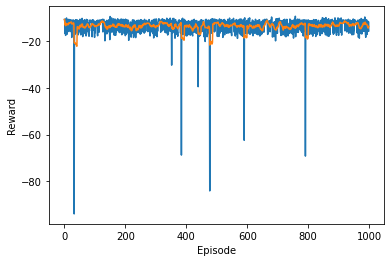

In [16]:
rewards = []
avg_rewards = []

for episode in tqdm(range(NUM_EPISODES)):
    time_step = env.reset()
    state = parse_obs(time_step.observation)
    noise.reset()
    episode_reward = 0
    episode_reward_history = []
    for step in range(DURATION):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        try:
            time_step_2 = env.step(denorm(action))
        except:
            print(f'Physics Error: {action}')
            break
        state_2 = parse_obs(time_step_2.observation)
        reward = time_step_2.reward
        agent.memory.push(state, action, reward, state_2, -1)
        state = state_2
        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)
        episode_reward += reward
        episode_reward_history.append(reward)
    print(f"episode: {episode}, "
          f"reward: {np.round(episode_reward, decimals=2)}, "
          f"average_reward: {np.mean(rewards[-10:])}")
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

agent.save(PATH_MODEL)

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [17]:
def memory_policy():
    t = 0

    def policy(time_step):
        nonlocal t
        state = parse_obs(time_step.observation)
        action = agent.get_action(state)
        action = noise.get_action(action, t)
        action = denorm(action)
        t += 1
        return action

    return policy


policy = memory_policy()
viewer.launch(env, policy=policy)